# Header and must run cells

In [6]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
from lmfit.models import SkewedGaussianModel
import re

# Please update these path varibles to your local machine.
env_session_file_location = r"\\172.24.54.234\\NAS-Lab28\\Data"
NAS_Path = r"\\172.24.54.234\\NAS-Lab28"
Plot_path= r"\\172.24.54.234\\NAS-Lab28\\Users\\Bane\\Plots"
# If you are having difficulty with finding the files, you can add a absolute path to the file location to the directory for you data.
locations= ["C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/",r"\\172.24.54.234/NAS-Lab28/Data/"]


# This will be phased out once update are made to use new database format
#Read in runlist and change cols to numbers
Runlist_DF = pd.read_csv(NAS_Path+"\\DataBases\\RunList.csv",index_col=False)
Runlist_DF["RN"]=Runlist_DF["Run No."]
number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]
Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)

# Read in Drift stack measurment database for drift, ext, col lengths and errors
Distance_Database=pd.read_csv(NAS_Path+"\\DataBases\\CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])

# Add in distance to run list and calc fields
skip=0
for i,run in enumerate(Runlist_DF["Run No."][skip:]):
    Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
    DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
    for key in DF.keys()[1:]:
        Runlist_DF.loc[i+skip,key] = DF[key]
# Calculate the drift, extraction and collection fields
Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)
# Calculate the drift distance and error
Runlist_DF["Drift Distance"] = Runlist_DF["Drift Length"] + Runlist_DF["Extraction Distance"] + Runlist_DF["Collection Distance"]
Runlist_DF["Drift Distance Error"] = np.sqrt(Runlist_DF["Drift Length Error"]**2 + Runlist_DF["Collection Distance Error"]**2 + Runlist_DF["Extraction Distance Error"]**2)

#Bg database
bgdb=pd.read_csv(NAS_Path+"\\DataBases\\bg_db.csv")

#make blank dataframe for background subtraction debugging
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})


## Collection of old Data

In [7]:

# Njoya et. al., NIMA 972,21  2020

#Njoya  velocties vs field [mm/us]. [V/cm]
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])

njoya_x=njxl
njoya_y=njyl


# Phys. Rev. 166, 871 - data

# L. S. Miller, S. Howe, and W. E. Spear
# Phys. Rev. 166, 871 – Published 15 February 1968
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])
ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])


# J. Yoo and W.F. Jaskierny 2015 JINST 10 P08011    --Data
AAA = [200, 0.148 , 0.003, 0.181 , 0.003, 1.22,
250, 0.157 , 0.004, 0.200 , 0.004, 1.27,
300, 0.162 , 0.003, 0.227 , 0.004, 1.40,
350, 0.166 , 0.003, 0.245 , 0.005, 1.48,
400, 0.167 , 0.003, 0.255 , 0.004, 1.53,
450, 0.174 , 0.004, 0.266 , 0.004, 1.53,
500, 0.177 , 0.003, 0.274 , 0.004, 1.55,
550, 0.180 , 0.004, 0.288 , 0.005, 1.60,
600, 0.184 , 0.003, 0.302 , 0.006, 1.64,
650, 0.186 , 0.003, 0.325 , 0.006, 1.74,
700, 0.189 , 0.006, 0.343 , 0.005, 1.82,
750, 0.191 , 0.003, 0.357 , 0.005, 1.87,
800, 0.193 , 0.003, 0.382 , 0.007, 1.98,
850, 0.194 , 0.003, 0.390 , 0.007, 2.01,
900, 0.193 , 0.003, 0.397 , 0.006, 2.05]


JINST_2015_dict={}

vs=[]
lds=[]
lds_e=[]
for i in np.arange(0,15,1):
    vs.append(AAA[i*6])
    lds.append(AAA[i*6+1]*10)
    lds_e.append(AAA[i*6+2])
JINST_2015_dict["Voltage"]=vs
JINST_2015_dict["DriftSpeed"]=lds
JINST_2015_dict["Error"]=lds_e


#J. B. Albert et al. (EXO-200 Collaboration) Phys. Rev. C 95, 025502 – Published 14 February 2017
EXO200= np.array([ [614.706, 565.686, 378.431, 186.275, 74.51, 38.235, 19.608],
          [1.981, 1.946, 1.784, 1.576, 1.271, 0.899, 0.484]])






## Functions

### Fitting functions

In [8]:
# Gaussian function definition
def congaussian(x,A,t,sigma):
    return A * np.exp(-(x-t)/10)* np.exp(-(x-t)**2/(2*sigma**2))

def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)

def sin_linear(x, amplitude, frequency, phase, slope, intercept):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + slope * x + intercept
def sin(x, amplitude, frequency, phase ):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)

def sin_exp(x, amplitude, frequency, phase, Tail_amp, Decay):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase)+Tail_amp*np.exp(Decay*x)
def simple_exp(x, Amp, Decay):
        return Amp*np.exp(Decay*x)

# Define a sinusoidal function for fitting
def sinusoidal(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf

def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b


### Useful preanalysis functions

In [14]:
def search_keywords(text, keywords):
    """
    Searches for a list of keywords in a given text and returns the matched ones.
    
    :param text: The input string to search within.
    :param keywords: A list of keywords to search for.
    :return: A list of matched keywords found in the text.
    """
    found_keywords = [kw for kw in keywords if re.search(rf'\b{re.escape(kw)}\b', text, re.IGNORECASE)]
    return found_keywords

#Function to retrieve run list information
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run is not in the list")
        return 0
    else:
        return DF
    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1


def isAnodeOff(run):
    return  GetRunInfo(run).iloc[0]["Anode V."] == 0 


def find_the_file(RN=596,debug=1):

    ''' find_the_file(Run number)
            This function attempt to find the data file location of of file based on the run number.
           Uses a list of possible locations (locations) to search through. It uses the function 
           GetRunInfo to grab the run information. It needs the date.
    '''
    global locations
    waveformpath=""
    RI = GetRunInfo(RN)
    if type(RI) == type(0) :
        return 0
    RI = RI.iloc[0]
    
    runstr = f"{RN}".zfill(5)

    dir_strs= [f"{RI.Date}-{runstr}",f"{RI.Date}/{RI.Date}-{runstr}"]
    located=0
    for loc in locations:
        for dir_str in dir_strs:
            fullpath= loc + dir_str
            if debug >=10:
                print(fullpath)
            if os.path.exists(fullpath):
                waveformpath=fullpath
                located=1
                if debug >=5 :
                    print("located : ", waveformpath)

    if located == 0:
        return 0
    else :
        return waveformpath

def GetWaveForm(runnumber,wavenumber=11,debug=1):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    RN=runnumber
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)
    

    # For left PC
    #waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveformpath=find_the_file(RN,debug=debug)
    waveform_dir = waveformpath


    if debug>=10:
        print(waveform_date)
        print(runnumber)
        print(waveform_dir)
        print(waveformpath)

    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        with open(waveform_fullpath) as f:
            unit_line=f.readlines()[1]

        if debug>=10:
            print(unit_line)
        units=unit_line.replace("(","").replace(")","").strip().split(",")
        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
        # rename columns
        DF=ReNameCols(DF)

        #if checkforshit(DF) == 0:
        #    return DF
        
        
            
        return DF

        
    else: # Did not find file
        print("Issue with file")
        return 0

def GetWaveForm_LaserPower(runnumber,wavenumber=11,debug=1):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    RN=runnumber
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)
    

    # For left PC
    #waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveformpath=find_the_file(RN,debug=debug)
    waveform_dir = waveformpath


    if debug>=10:
        print(waveform_date)
        print(runnumber)
        print(waveform_dir)
        print(waveformpath)
    if waveform_dir ==0:
        return pd.DataFrame()

    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        with open(waveform_fullpath) as f:
            lines = f.readlines()
        unit_line=lines[1]
        
        units=unit_line.replace("(","").replace(")","").strip().split(",")

        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
    
    

        #if checkforshit(DF) == 0:
        #    return DF
        
        
            
        return DF

        
    else: # Did not find file
        print("Issue with file")
        return 0


def checkforshit(DF):
    bad=0
    for key in DF.keys():
        if type(DF[key].iloc[1] == type("str")):
            bad =key
        else:
            continue

    return bad
    

# this should correct the colomn names of the avg cath and anode. need to add incorrect options to list
def ReNameCols(DF):
    chann_name_options=[["Avg UV","Avg Anode"],
                        ['Average Cathode (2)', 'Average Anode (2)'],
                        ['average(Cathode)', 'average(Anode)']]
    Correct_names=["Avg Cathode","Avg Anode"]
    keys=DF.keys()
    if Correct_names[0] in keys and Correct_names[1] in keys:
        return DF
    for chan_options in chann_name_options:
        if chan_options[0] in keys:
            DF =DF.rename(columns={chan_options[0]: Correct_names[0]})
        if chan_options[1] in keys:
            DF =DF.rename(columns={chan_options[1]: Correct_names[1]})

    return DF



### SIn background

In [39]:


def GetSinBG(x_data,y_data,time_start=0,time_stop=10,stepsize=100,debug=10,plot=True):
    
    x_fit=[]
    y_fit=[]
    
    if np.mean(y_data) <= 0.001:
        print("issue with weird data")
        return [0,0,0,0,0],[0,0,0,0,0]

    if len(x_data) <=1 or len(y_data)<=1 or len(x_data) != len(y_data):

        print("X and Y need to be equal in length and need two more data points")
        print(" X: ", len(x_data), " Y :" ,len(y_data))
        return np.zeros(len(x_data)),np.zeros(len(y_data))
    
    if plot: sin_figure, sin_ax =plt.subplots(figsize=(9,4))


    # Determine fitting limits
    time_resolution= x_data[1] - x_data[0]
    index_start = int(time_start/time_resolution)
    index_stop = int(time_stop/time_resolution)
    if debug>=10: print("Start ",time_start,index_start," stop ",time_stop,index_stop)
    
    if plot:
        sin_ax.errorbar(x_data,y_data,alpha=0.75,
    linestyle=(0, (5, 1)),c="gray",label="Data")
        sin_ax.legend()

    # smooth out the data
    smooth_slice=slice(int(stepsize/2),-(int(stepsize/2)+1))
    smooth_ydata=np.convolve(y_data,
     np.ones(stepsize)/stepsize,mode="same")[smooth_slice]
    smooth_xdata=x_data[smooth_slice]
    if plot:sin_ax.errorbar(smooth_xdata,smooth_ydata,
    linestyle=(0, (5, 1)),label="Smooth Data")

    # Prepare for fit
    x_fitdata=smooth_xdata[index_start:index_stop-int(stepsize/2)]
    y_fitdata=smooth_ydata[index_start:index_stop-int(stepsize/2)]
    #if plot:sin_ax.errorbar(x_fitdata,y_fitdata,fmt=":",label="Fit Data")

    ## fit the expontial tail first 
    if y_fitdata[0] < y_fitdata[-1]:
        print("Weird structure skipping sin fit")
        return [0,0,0,0,0],[0,0,0,0,0]

    p0_tail_only = [np.max(y_fitdata),-0.001]
    bounds_tail_only = [np.max(y_fitdata)*.75,-0.01],[np.max(y_fitdata)*1.25,0.0001]
    if debug >=10:
        print("Tail Only")
        print("P0", p0_tail_only)
        print("bounds",bounds_tail_only)

    params_tail_only, covariance_tail_only = curve_fit(simple_exp, 
        x_fitdata, y_fitdata,p0=p0_tail_only,bounds=bounds_tail_only)


    x_fit=smooth_xdata
    y_fit_tail_only=simple_exp(x_fit,*params_tail_only)
    if plot:
        sin_ax.errorbar(x_fit,y_fit_tail_only,
        linestyle=":",label="Only tail")
        

    if debug>=5: print("Only exp tail paramaters", params_tail_only)

    # subtracted the tail

    tail_sub_fitdata = y_fitdata - simple_exp(x_fitdata,*params_tail_only)

    
    #po = amp,freq, phase, exp amp, decay
    #p0=[max(y_fitdata)/2-min(y_fitdata)/2,0.25,0.5,params_tail_only[0],params_tail_only[1]]
    #bounds=[0,0.0001,-np.pi,params_tail_only[0]*0.8,params_tail_only[1]*1.2],[p0[0],1.0,np.pi,params_tail_only[0]*1.2,params_tail_only[1]*0.8]

    # po for freq. try to count number of local max for time range

    # amp, freq, phase,
    p0 = [(np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2, 0.14,0 ]
    bounds =[0,0,-3.14 ],[((np.max(tail_sub_fitdata) - np.min(tail_sub_fitdata))/2 )*1.3,
            1,3.14]


    if debug>=5:
        print("Fit P0",p0)
        print("Bounds",bounds)
    params, covariance = [0,0,0],[[0,0,0],[0,0,0],[0,0,0]]
    try: 
        params, covariance = curve_fit(sin, 
            x_fitdata, tail_sub_fitdata,p0=p0,bounds=bounds)
    except:
        print("Issue with sin fit")

    if debug >=5:
        print("Parameters", np.round(params,3))
    if debug>=10: print("Covariance",covariance)
    
    x_fit=smooth_xdata
    y_fit=sin(x_fit,params[0],params[1],params[2])
    if plot:
        sin_ax.errorbar(x_fitdata,sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]),
        linestyle="--",label="Fit Results")
        sin_ax.errorbar(x_fit,y_fit+params_tail_only[0],linestyle="--",label="Sin Fit")
        sin_ax.errorbar(x_fit[::stepsize],(smooth_ydata-y_fit)[::stepsize],
                        color="black",fmt="-.",linewidth=0.75,label="Subtracted")

    y_fit_Stddev=sin_exp(x_fitdata,params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1])
    dev = np.sqrt(np.sum(abs(y_fit_Stddev-y_fitdata)**2)/len(y_fit))
    if debug >=5: print("Fit deviation from fitting data", dev)
    if dev>1:
        print("\t\t!!!!!!WARNING!!!!!!!!!  Issue with sin fit Large Deviation")
    #print((y_fit_Stddev-y_fitdata)/y_fitdata )
    if plot:
        sin_ax.grid()
        sin_ax.legend()
        #plt.xlim(time_start-12,time_stop-8)
        #plt.ylim(params[4] + params[3]*time_stop,params[4]*1.1)

    return [params[0],params[1],params[2],
            params_tail_only[0], params_tail_only[1]],[covariance[0][0],covariance[1][1],covariance[2][2],covariance_tail_only[0][0],covariance_tail_only[1][1]]





### Analyze run

In [11]:
def AnalyzeRun(runs=[200],stepcounts=[100],diffsizes=[200],debug=1,plot=True,savefig=True):

    global Plot_path

    anode_delay=[]
    cathode_delay=[]
    drift_field_list=[]
    k=0
    ana_list=[]
    if type(runs)==type(1):
        runs=[runs]
    if type(stepcounts)==type(1):
        stepcounts=[stepcounts]
    if type(diffsizes)==type(1):
        diffsizes=[stepcounts]
    
    for run in runs:


        if isAnodeOff(run):
            print("Skipping this anode off run")
            continue

        for diffsize in diffsizes:
            for stepcount in stepcounts:
            

                analysis_dict={}
                bg_run=GetBGRun(run)
                if debug >= 1: 
                    print("Run " , run, "  BG- ", bg_run)
                    print("Stepsize %i , DiffSize %i"%(stepcount,diffsize))
                
                
                # Grab the main and background waveforms
                try:
                    DF=GetWaveForm(run)
                except:
                    print("Issue with run " ,run)
                    continue
                try:
                    if bg_run ==-1:
                        n=len(DF["Time"])
                        bgDF=pd.DataFrame({"Avg Cathode": [0] *n , "Avg Anode": [0] * n})
                    else:
                        bgDF=GetWaveForm(bg_run)
                except Exception as e:
                    print(f"An error occurred: {e}")
                    print("Issue with bg " , bg_run)
                    continue

                
                    
                timeresolution = np.round(DF["Time"].iloc[1] - DF["Time"].iloc[0],5)
                if debug >=4: print("Time step size: ", round(timeresolution,5))
                RI = GetRunInfo(run)
                drift_field=RI["Drift Field"].iloc[0]
                bgRI = GetRunInfo(bg_run)

                # Find the baseline normalization of each waveform
                mod_step=int((stepcount * np.round(0.004/timeresolution,4)))
                res_mod=np.round(0.004/timeresolution,3)
                Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0
                if debug >=10: print("Mod step %i, res mod %0.4f, Zero time index %i, Zero time %0.4f"%(mod_step,res_mod,Zero_time,DF["Time"].iloc[Zero_time]))
                #Get Normalizations for setting baseline to zero

                anodenorm=np.average(DF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                cathnorm =np.average(DF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_anorm =np.average(bgDF["Avg Anode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])
                bg_cnorm =np.average(bgDF["Avg Cathode"][Zero_time-int(500*res_mod):Zero_time-int(50*res_mod)])

                #Normalize signal and BG then subtract, make correct o bg if too big
                bg_y_factor=1
                anode_sig=DF["Avg Anode"] - anodenorm
                bg_a_sig_full =bgDF["Avg Anode"] - bg_anorm

                DF["Avg Anode Norm"]=anode_sig
                DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG
                if debug >=5:
                    print("starting sin removal")
                Anode_sin_params,Anode_sin_covariance=GetSinBG(DF["Time"]
                        ,DF["Avg Anode Norm"],
                        time_start=26,time_stop=50,debug=debug,stepsize=stepcount,plot=plot)
                if debug >=5:
                    print("starting sin removal for bg")
                AnodeBG_sin_params,AnodeBG_sin_covariance=GetSinBG(DF["Time"]
                        ,bg_a_sig_full[:len(DF["Time"])],
                        time_start=26,time_stop=50,debug=debug,stepsize=stepcount,plot=plot)
                

                Anode_noise_frq=Anode_sin_params[1]
                Anode_noise_Amp=Anode_sin_params[0]
                Anode_signal_tail=Anode_sin_params[4]

                DF["Anode Signal"]=  DF["Smooth Anode Norm"] - sin(DF["Time"],Anode_sin_params[0],Anode_sin_params[1],Anode_sin_params[2])
                DF["BG Signal"] = bg_a_sig_full- sin(DF["Time"],AnodeBG_sin_params[0],AnodeBG_sin_params[1],AnodeBG_sin_params[2])
                DF["Smooth BG Signal"]=np.convolve(DF["BG Signal"],np.ones(stepcount)/stepcount,mode="same")
                # Get Noise BG        
                #DF["Smooth Anode Norm"]=np.convolve(DF["Avg Anode Norm"],np.ones(stepcount)/stepcount,mode="same")
                #split bg into 2 sections
                split_loc=Zero_time+500                
                bg_a_sig_1=bg_a_sig_full[:split_loc* int(0.004/timeresolution)]
                bg_a_sig_2=bg_a_sig_full[split_loc* int(0.004/timeresolution):]
                #roll the second bit
                bg_a_sig_2=bg_a_sig_2.rolling(mod_step*10,min_periods=1,center=True).mean()
                #bring them together
                bg_a_sig=np.concatenate([bg_a_sig_1,bg_a_sig_2])
                if debug>=4:
                    print("DF length ",len(DF["Time"]),"resolution", timeresolution)
                    print("\n Time @ zero \t time @ 0 + 500")
                    print(DF["Time"].iloc[Zero_time],"\t",DF["Time"].iloc[split_loc* int(0.004/timeresolution)] )
                    print("")
                    

                #bg_a_sig=bg_a_sig.rolling(mod_step*100,min_periods=1)#np.concatenate([bg_a_sig_fist_bit,bg_a_sig_last_bit])
                
                if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
                    bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])
                    if debug >=10: print("bg too big, factor:", bg_y_factor)
                if len(anode_sig) <= len(bg_a_sig):
                    anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor
                if len(anode_sig) > len(bg_a_sig):
                    anode_sub= anode_sig[:len(bg_a_sig)]-bg_a_sig*bg_y_factor
                DF["Anode Sub"] = DF["Anode Signal"] - DF["Smooth BG Signal"]*bg_y_factor


                #take diff
                rolling= anode_sub.rolling(mod_step).mean()
                smooth_slice=slice(int(stepcount/2),-(int(stepcount/2)+1))
                DF["Smooth Anode Sub"] = np.convolve(DF["Anode Sub"],np.ones(stepcount)/stepcount,mode="same")

                if debug >=10: print("modifed diffsize ",int(diffsize*res_mod))
                
                anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])

                DF["Anode Diff"] =  DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                anode_diff= DF["Smooth Anode Sub"].diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])
                


                if 1==1: fig, ax = plt.subplots(2,2, figsize=(12,7))

                #Plot 
                if 1==1:# plot: 
                    ax[0][1].errorbar(x=DF["Time"][::mod_step],y=DF["Anode Signal"][::mod_step],  label="Anode Signal")
                    if len(DF["Time"][::]) <= len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][::],y=bg_a_sig_full[:len(DF["Time"][::])]*bg_y_factor,  label="BG")
                    if len(DF["Time"][::]) > len(bg_a_sig_full):
                        ax[0][1].errorbar(x=DF["Time"][:len(bg_a_sig_full):],y=bg_a_sig_full[::]*bg_y_factor,  label="BG")
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Smooth BG Signal"]*bg_y_factor,  label="Background")                   
                    ax[0][1].errorbar(x=DF["Time"][::],y=DF["Anode Sub"][::],  label="Subtracted")
                    #ax[0][1].errorbar(x=DF["Time"][::stepcount],y=DF["Smooth Anode Sub"][::stepcount],  label="Smooth Subtracted")

                    ax[1][1].errorbar(x=DF["Time"][int(stepcount):-int(stepcount):stepcount],y=DF["Anode Diff"][int(stepcount):-int(stepcount):stepcount],  label="Derivative")

                #Fit the derivative with a guassian
                fit_start_index = np.where(abs(DF["Time"] - 5) <= 10*timeresolution)[0][-1] 
                fit_stop_index = np.where(abs(DF["Time"] - 25) >= 10*timeresolution)[0][-1] 

                #P0 for guassian fit
                #P0 for amp
                if debug >=8:
                    print("fit start",fit_start_index,DF["Time"][fit_start_index])
                    print("fit stop",fit_stop_index,DF["Time"][fit_stop_index])
                diff_max=np.max(anode_diff[fit_start_index:fit_stop_index]) #Amp value
                max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
                max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location
                
                #P0 for sigma 
                half_max_ind=[]
                k=0
                while len(half_max_ind) <=1:
                    half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
                    k=k+1
                    if k >=10:
                        if debug>1:
                            print("Cant find second half max for anode")
                        break
                try :
                    half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
                except : 
                    half_max_sep = timeresolution*4 #why 4? Need to address !flag!
                
                #anode Fitting data
                sec_fit_ind = max_loc_ind[0]+int(np.floor(20/timeresolution))
                if debug >=10:print("sec fit", max_loc_ind[0]+sec_fit_ind,DF["Time"][sec_fit_ind])
                xfit = np.array(DF["Time"][fit_start_index:sec_fit_ind])
                yfit = np.array(anode_diff[fit_start_index:sec_fit_ind].fillna(0))
                        
                p0 = [diff_max,max_time[0],half_max_sep/2]
                if debug >=5: print("Anode p0 ", np.round(p0,4))
                
                # Set up to loop through a few fitting attempts
                max_fits, sigma,A,z= 5,10,0,0
                Amp=diff_max    
                xfit_tmp=xfit
                yfit_tmp=yfit
                anode_bounds=[[Amp*0.25,p0[1]*0.75,0],[Amp*2,p0[1]*1.25,p0[2]*2]]

                anode_V= RI["Anode V."].iloc[0]
                ppot=[0,0,0,0]
                pcov=[[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
                ###
                fig2,bx=plt.subplots(figsize=(5,4))
                fig3,dx=plt.subplots(figsize=(5,4)) 
                if anode_V>0:
                        
                    while sigma >=1 or abs((A-Amp))/Amp >= 0.1:

                        ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000,bounds=anode_bounds)
                        z=z+1
                        sigma=ppot[2]
                        A=ppot[0]
                        if sigma <= 1 and abs((A-Amp))/Amp <= 0.1:
                            if debug>=5: 
                                print("Good fit, attempts",z)
                                print("Sigma ",sigma)
                                print("amp ",A)
                                print("mu ",ppot[1])

                            break

                        if z >=max_fits:
                            break

                        #adjust fitting range to attempt a new fit
                        first_index=np.max([max_loc_ind[0]-(max_fits+2-z)*500,fit_start_index])
                        last_index=np.min([max_loc_ind[0]+(max_fits+2-z)*500,sec_fit_ind])

                        if debug>=10:
                            print("old Results")
                            print("Sigma ",sigma)
                            print("amp ",A)
                            print( "(guess-A)/A ",abs((A-Amp))/Amp)
                            print("mu ",ppot[1])


                            print("new Fit ",z)
                            print("last index",last_index, " Time ", DF["Time"][last_index] )
                            print("first index",first_index, "time", DF["Time"][first_index] )


                        yfit_tmp = anode_diff[first_index:last_index+1]
                        xfit_tmp = DF["Time"].iloc[first_index:last_index+1]
                        # print(xfit_tmp)
                        if debug>=5:print("Fitting limits", xfit_tmp[first_index],xfit_tmp[last_index])
                    #End of fitting loop for anode

                if ppot[0] <0:
                    print("Bad fit skipping run ", run)
                    continue

                if debug>=5:
                    print("Fit parms\n",ppot)
                    print("Fit cov\n",np.diagonal(pcov))
                        
                #plot the guassian
                if 1==1:#plot: 

                #Find the values use to determine the anode amplitude
                    avg_len=int(2.5/timeresolution)
                    alen_min=int(.5/timeresolution)
                    backsteps=int(1./timeresolution)
                    avg_min_1=max_loc_ind[0]-backsteps-alen_min
                    avg_min_2=max_loc_ind[0]-backsteps
                    anode_avg_AM=np.average(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min=np.average(DF["Smooth Anode Sub"][avg_min_1:avg_min_2])
                    anode_avg_max_stdev=np.std(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min_stdev=np.std(DF["Smooth Anode Sub"][avg_min_1:avg_min_2])

                    anode_signal_with_sub=anode_avg_AM-anode_avg_min
                    anode_signal_with_sub_error = np.sqrt(anode_avg_max_stdev**2 + anode_avg_min_stdev**2)
                    if debug > 5:
                        print("Anode std")
                        print("min ", anode_avg_min_stdev)
                        print("max ", anode_avg_max_stdev)
                        print("error ", anode_signal_with_sub_error)

                    avg_max_array=anode_avg_AM*np.ones(len(DF["Smooth Anode Sub"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array=anode_avg_min*np.ones(len(DF["Smooth Anode Sub"][avg_min_1:avg_min_2]))

                    anode_avg_AM_notsub=np.average(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len])
                    anode_avg_min_notsub=np.average(DF["Anode Signal"][avg_min_1:avg_min_2])

                    avg_max_array_notsub=anode_avg_AM_notsub*np.ones(len(DF["Anode Signal"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len]))
                    avg_min_array_notsub=anode_avg_min_notsub*np.ones(len(DF["Anode Signal"][avg_min_1:avg_min_2]))
                    anode_signal_notsub=anode_avg_AM_notsub-anode_avg_min_notsub

                    bx.errorbar(DF["Time"],DF["Smooth Anode Sub"], label="Anode Signal")
                    dx.errorbar(DF["Time"],DF["Smooth Anode Sub"], label="Anode Signal")
                    # bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                    #     avg_max_array,
                    #     fmt=" ",marker="s",alpha=0.25,markersize=5,label="Max Sig.")
                    # bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                    #     avg_min_array,color="red",
                    #     fmt=" ",marker="s",alpha=0.25,markersize=5,label="Min Sig.")
                    
                    #bx.errorbar(DF["Time"],DF["Anode Signal"])
                    #bx.errorbar(DF["Time"][max_loc_ind[-1]:max_loc_ind[-1]+avg_len],
                    #    avg_max_array_notsub,alpha=0.25,color="Orange",
                    #     fmt=" ",marker="s",markersize=5,label="Max Sig.")
                    # bx.errorbar(DF["Time"][avg_min_1:avg_min_2],
                    #     avg_min_array_notsub,alpha=0.25,color="red",
                    #     fmt=" ",marker="s",markersize=5,label="Min Sig.")
                    bx.grid()
                    bx.set_xlabel("Time[us]")
                    bx.set_ylabel("[mV]")
                    dx.grid()
                    dx.set_xlabel("Time[us]")
                    dx.set_ylabel("[mV]")
                    if debug >=5:
                        print("anode strength, with/w/o", anode_signal_with_sub,anode_signal_notsub)
                    
                    
                    guass_y = gaussian(xfit_tmp,ppot[0],ppot[1],ppot[2])
                    ax[1][1].errorbar(x=xfit_tmp,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

                ap0=p0
                appot=ppot    
                apcov=pcov
##########################################
##########################################
##########################################
                #Cathode analysis
                #Normalize signal and BG then subtract
                cath_sig=DF["Avg Cathode"] - cathnorm
                diff_time_size=(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
                cath_diff = cath_sig.diff(int(diffsize*res_mod))/diff_time_size
                bx.errorbar(DF["Time"],np.abs(cath_sig)/10, label="Cathode Signal/10")
                bx.legend()
                dx.errorbar(DF["Time"],np.abs(cath_sig), label="Cathode Signal")
                dx.legend()

                if 1==1:#plot: 
                    ax[0][0].errorbar(x=DF["Time"][::mod_step],
                                    y=cath_sig[::mod_step],   label="Cathode Signal")

                    ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
                
                #Cathode Fitting data
                xfit = np.array(DF["Time"][:])
                yfit = np.array(cath_diff[:].fillna(0))
                
                #guess for cathode fit

                min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for min locaiton
                min_time= np.array(DF["Time"])[min_loc_ind][0]

                k=0
                half_min_ind=[]
                while len(half_min_ind) <=1:
                    half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
                    k=k+1
                    if k >=45:
                        print("Cant find second half max")
                        break
                
                half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
                
                
                p0 = [np.min(yfit),min_time,half_min_sep]
                if debug >=5: print("cathode p0", np.round(p0,4))
                #Fit cathode deriv
                ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)
                

                
                if debug>=5:
                    print("Fit parms\n",ppot)
                    print("Fit cov\n",np.diagonal(pcov))

                if 1==1:#plot:
                    guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
                    ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                                    label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))
                    
                    Xlims=(-7.5,20)
                    ax[1][0].grid()
                    ax[1][0].legend()
                    ax[1][0].set_xlabel("Time[us]")
                    ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
                    ax[1][0].minorticks_on()
                    ax[1][0].set_xlim(Xlims)

                    ax[1][1].grid()
                    ax[1][1].legend()
                    ax[1][1].set_xlabel("Time[us]")
                    ax[1][1].set_ylabel("Anode Derivative [mV/us]")
                    ax[1][1].set_xlim(Xlims)

                    ax[0][0].grid()
                    ax[0][0].legend()#loc="upper right")
                    ax[0][0].set_xlabel("Time[us]")
                    ax[0][0].set_ylabel("Cathode Signal [mV]")
                    ax[0][0].set_xlim(Xlims)
                    cath_strength=np.abs(np.min(cath_sig[::]) -np.max(cath_sig[::]))
                    ax[0][0].text(-5,-cath_strength+2,f" Cathode \n {np.abs(cath_strength):.2f} mV")

                    ax[0][1].grid()
                    ax[0][1].legend()#loc="upper right")
                    ax[0][1].set_xlabel("Time[us]")
                    ax[0][1].set_ylabel("Anode Signal [mV]")
                    ax[0][1].set_xlim(Xlims)
                    ax[0][1].text(appot[1]-3,anode_signal_with_sub,f"Anode \n {np.abs(anode_signal_with_sub):.2f} mV")
                
                    fig.suptitle("Run %i\n %i %i"%(run,stepcount,diffsize))
                    plt.tight_layout()


                # Need to develop funciton to check if this fit needs to be replaced. !flag! 
                analysis_dict["Run"]=run
                analysis_dict["Anode P0"]=ap0
                analysis_dict["Anode Delay Time"] = appot[1]
                analysis_dict["Anode Delay Sigma"] = appot[2]
                analysis_dict["Anode Fit Errors"] = np.diagonal(apcov)
                #analysis_dict["Anode Amp"] = appot[0]

                analysis_dict["Anode Amp"] = anode_signal_with_sub
                analysis_dict["Anode Amp Error"] =anode_signal_with_sub_error
                analysis_dict["Anode Amp notsub"] = anode_signal_notsub

                analysis_dict["Cathode P0"]=p0
                analysis_dict["fit stepsize"]=stepcount
                analysis_dict["fit diffsize"]=diffsize
                analysis_dict["Cathode Delay Time"] = ppot[1]
                analysis_dict["Cathode Delay Sigma"] = ppot[2]
                analysis_dict["Cathode Amp"] = ppot[0]
                analysis_dict["Cathode Fit Errors"] = np.diagonal(pcov)
                analysis_dict["Cathode Wave Amp"] = np.abs(np.min(cath_sig[::]) -np.max(cath_sig[::]))
                analysis_dict["Cathode Wave Amp Error"] = 0.005*analysis_dict["Cathode Wave Amp"]
                analysis_dict["Anode Noise frq"]=Anode_noise_frq
                analysis_dict["Anode Noise Amp"]=Anode_noise_Amp
                analysis_dict["Anode Signal Tail"]=Anode_signal_tail
                #drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
                #extract_field=RI["Extraction Field"].iloc[0]
                #analysis_dict["Drift Field"] =drift_field
                #analysis_dict["Extraction Field"] =extract_field
                #analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
                #analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
                #analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
                #analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
                #analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
                #analysis_dict["Drift Length"] = float(RI["Drift Length"].iloc[0])
                
                
                ri = GetRunInfo(run).reset_index().iloc[0]
                ridict=ri.to_dict()
                
                run_dict={**ridict, **analysis_dict}
                run_dict["index"]=run                

                
                ana_list.append(run_dict)
                
                if savefig:
                    plot_filename="Run%i_stp%i_diff%i.png"%(run,stepcount,diffsize)
                    plot_fullpath=Plot_path+"\\"+plot_filename
                    fig.savefig(plot_fullpath)
                if plot == False:
                    plt.close(fig2)
                    plt.close(fig)

      
    return pd.DataFrame.from_dict(ana_list)

### Drift vel and Lifetime analysis

In [12]:
def DV_ana(DF):
    DF.loc[:,"Drift Vel"] = DF["Drift Distance"]/(DF["Anode Delay Time"] -(DF["Cathode Delay Time"]))

    DF.loc[:,"Drift Time"]=(DF["Anode Delay Time"] -DF["Cathode Delay Time"])

    #DF.loc[:,"Drift Time Error"]=DF.apply(lambda row: np.sqrt(row["Anode Fit Errors"][1]**2 + row["Cathode Fit Errors"][1]**2), axis=1 )


    DF.loc[:,"Drift Time Error"]= np.sqrt((DF["Anode Delay Sigma"]/1)**2 + (DF["Cathode Delay Sigma"]/1)**2)
    Avg_Vel_DF=DF.groupby("Run")["Drift Vel"].mean()
    Std_dev_DF=DF.groupby("Run")["Drift Vel"].std()


    DF.loc[:,"Drift Vel Error"]= np.sqrt(DF["Drift Vel"]**2*( (DF["Drift Distance Error"]/DF["Drift Distance"])**2 + (DF["Drift Time Error"]/DF["Drift Time"])**2 ) )
    DF.loc[:,"Avg Drift Vel"]= DF['Run'].map(Avg_Vel_DF)
    DF.loc[:,"Avg Drift Vel STD"]= DF['Run'].map(Std_dev_DF)
    return DF


def LT_ana(DF):
    anode_preamp_gain=DF["Anode Preamp Gain"]
    catho_preamp_gain=DF["Cathode Preamp Gain"]
    
    Q_c=np.abs(DF["Cathode Wave Amp"]*catho_preamp_gain)
    Q_a=np.abs(DF["Anode Amp"]  *anode_preamp_gain)/0.81  #adjust Q_a by total grid transparncy
    
    Q_c_E = Q_c*np.sqrt( (DF["Cathode Wave Amp Error"]/DF["Cathode Wave Amp"])**2 + (DF["Cathode Preamp Error"]/catho_preamp_gain)**2 )
    Q_a_E = Q_a*np.sqrt( (DF["Anode Amp Error"]/DF["Anode Amp"])**2 + (np.array(DF["Anode Preamp Error"].astype(float))/np.array(anode_preamp_gain))**2 )

    DF["Anode Q"]=Q_a
    DF["Anode Q Error"]=Q_a_E
    DF["Cathode Q"]=Q_c
    DF["Cathode Q Error"]=Q_c_E
    DF["LifeTime"] = (DF["Anode Delay Time"]-DF["Cathode Delay Time"]) / ( np.log(Q_c/Q_a))
    
    LE_A= (( - DF["Drift Time"] * Q_a_E) /(np.log(Q_c/Q_a)**2 * Q_a))**2
    LE_t= ( (1/(np.log(Q_c/Q_a)))* DF["Drift Time Error"]  )**2
    LE_C= ((DF["Drift Time"] * Q_c_E) /(np.log(Q_c/Q_a)**2 * Q_c))**2


    ratio_e_per = np.sqrt( ( Q_c_E/Q_c)**2 + (Q_a_E/Q_a)**2 )
     
    DF["Lifetime Error"] = np.sqrt( LE_A + LE_t + LE_C)
    
    return DF





# Analysing runs

## Runs from Oct 2024 to Dec 3rd 2024

In [63]:
Runlist_Oct11=[176,177,178,179,180,181,182]
Runlist_Nov1 =[334,333,332,331,330]
Runlist_Nov11=[385,386,387,388,389]
Runlist_Dec3 =[437,438,439,440,441,442,443,444,445,446]
Runlist_Dec13_DS1=[503,507,511,515,519]
Runlist_Dec13_DS2=[584,586,588]
Runlist_Nov15_anode_Sweep=[423,424,425,426,427,428,429,430]
Runlist_Jan28_DS= [599,600,601,602,603,604]
Runlist_Jan28_ExtS = [611,612,613,614,615,616,617]

Runlist_Dec13_ExtS = [522,524,526,528,530,532,534]

Dec13Full_runlist=[502,503,506,507,510,511,514,515,518,
519,536,538,540,540,590,546,592,542,594,544,584,586,588,
548,550,552,554,556,558,560,562,564,566,568,570,572,574,
576,578,580,582]
#Dec13Full_runlist=[507,538]
Dec13_cathosweep_runlist=[522,523,524,525,526,527,528,529,530,531,532,533,534,535]


Run  176   BG-  208
Stepsize 100 , DiffSize 100
Run  177   BG-  209
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  178   BG-  210
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  179   BG-  211
Stepsize 100 , DiffSize 100
Run  180   BG-  212
Stepsize 100 , DiffSize 100
Run  181   BG-  213
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  182   BG-  214
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  334   BG-  339
Stepsize 100 , DiffSize 100
Run  333   BG-  338
Stepsize 100 , DiffSize 100
Run  332   BG-  337
Stepsize 100 , DiffSize 100
Run  331   BG-  336
Stepsize 100 , DiffSize 100
Run  330   BG-  335
Stepsize 100 , DiffSize 100
Run  385   BG-  394
Stepsize 100 , DiffSize 100
Run  386   BG-  393
Stepsize

C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:204: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3,dx=plt.subplots(figsize=(5,4))


Run  439   BG-  461
Stepsize 100 , DiffSize 100


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,bx=plt.subplots(figsize=(5,4))


Run  440   BG-  462
Stepsize 100 , DiffSize 100


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if 1==1: fig, ax = plt.subplots(2,2, figsize=(12,7))


Run  441   BG-  463
Stepsize 100 , DiffSize 100
Run  442   BG-  464
Stepsize 100 , DiffSize 100
Run  443   BG-  465
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  444   BG-  466
Stepsize 100 , DiffSize 100
Run  445   BG-  467
Stepsize 100 , DiffSize 100
Run  446   BG-  468
Stepsize 100 , DiffSize 100


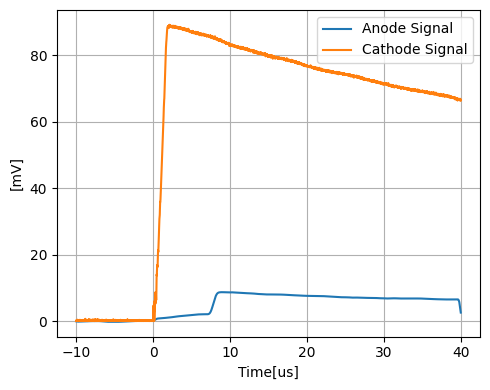

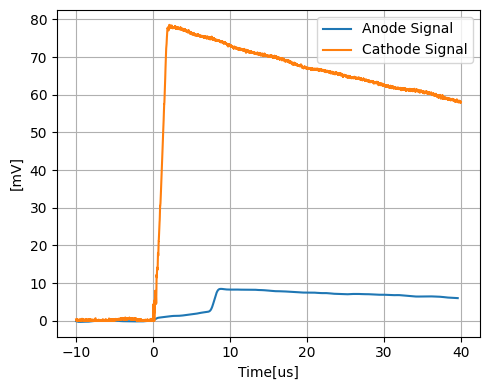

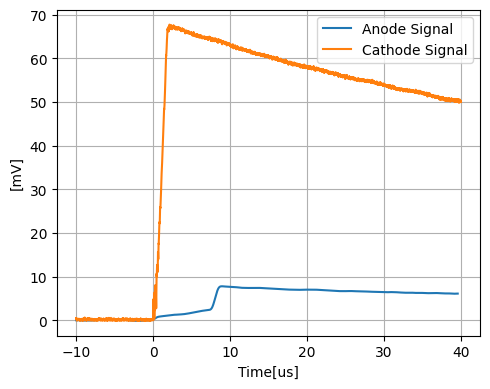

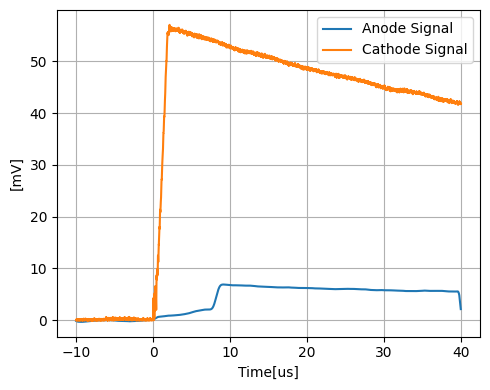

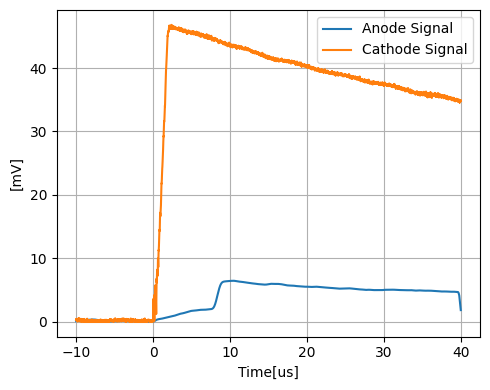

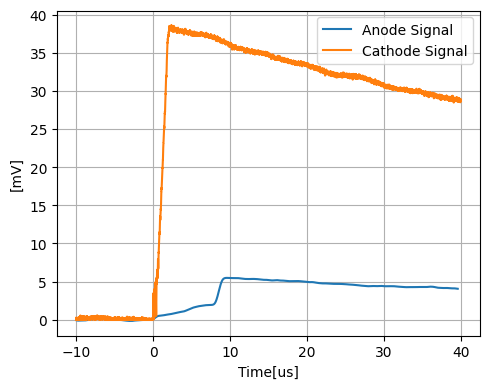

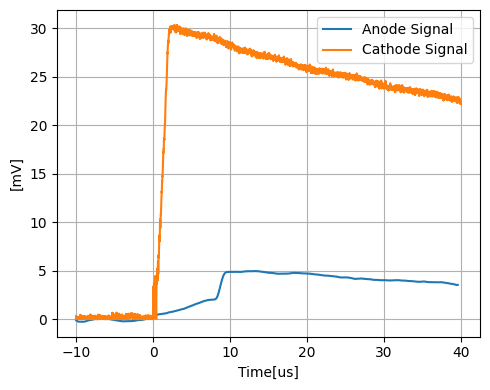

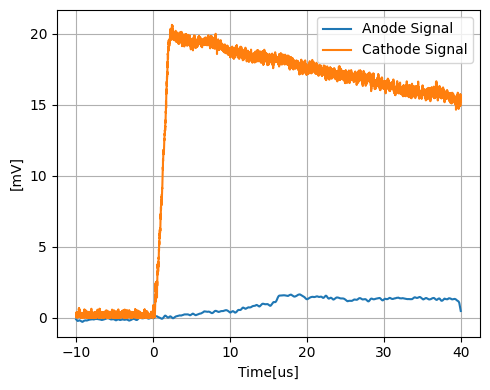

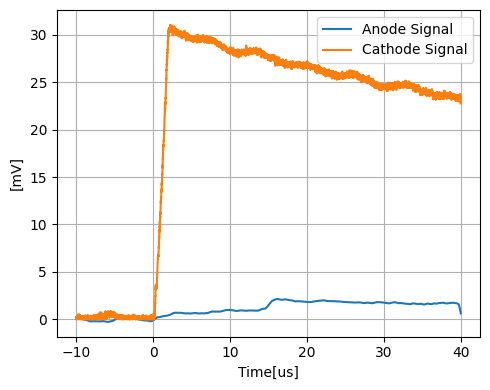

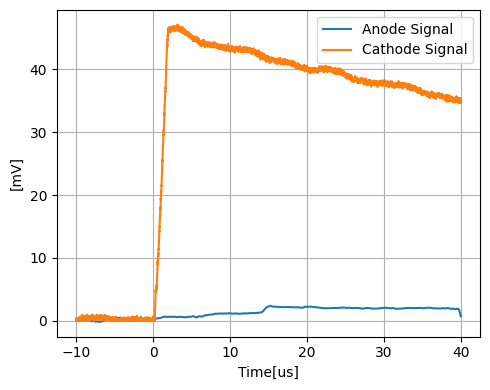

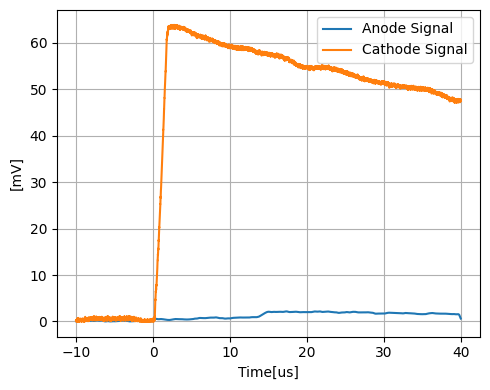

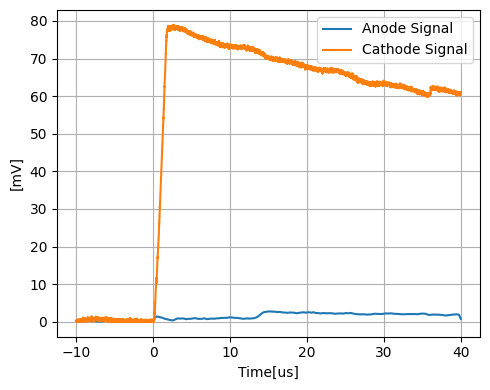

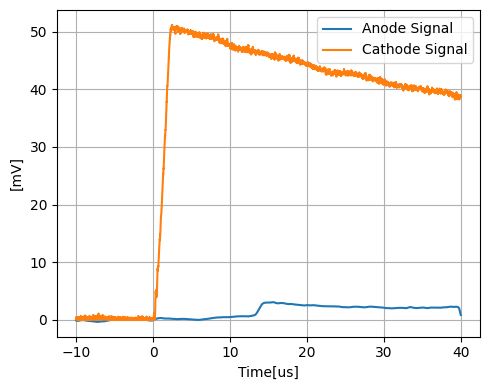

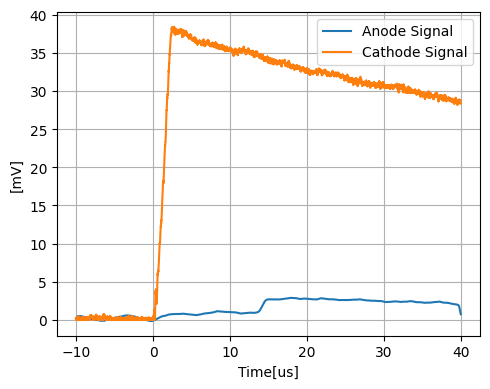

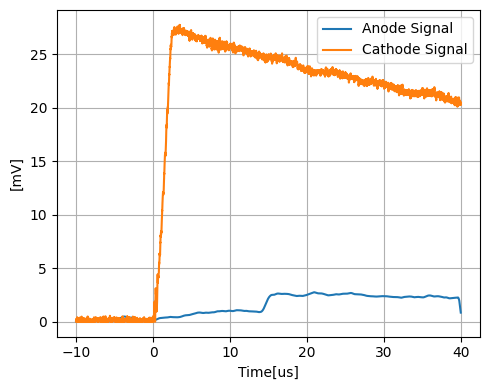

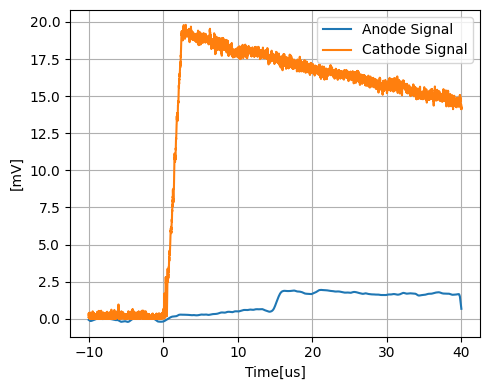

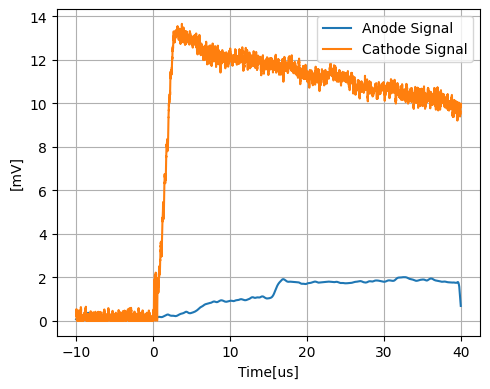

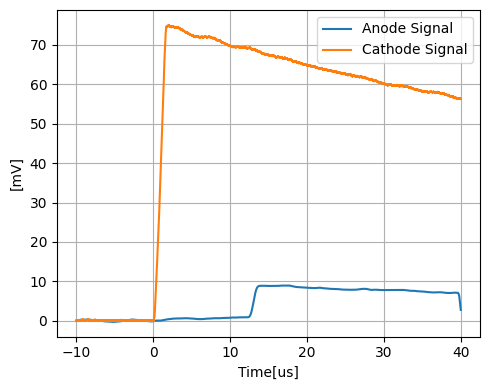

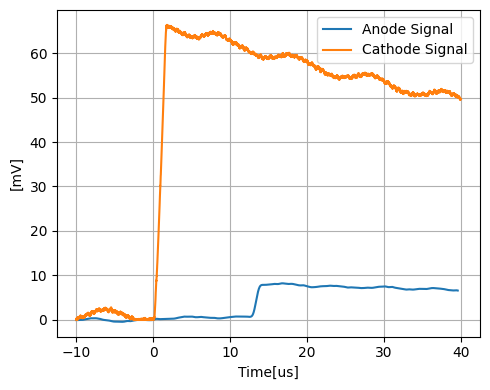

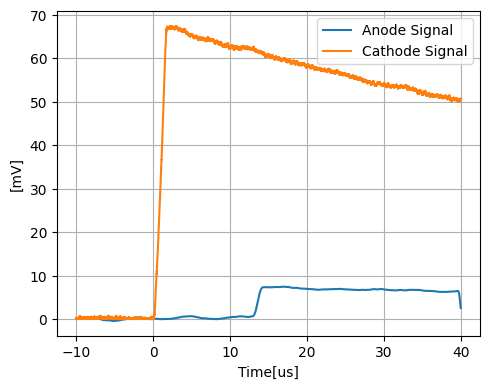

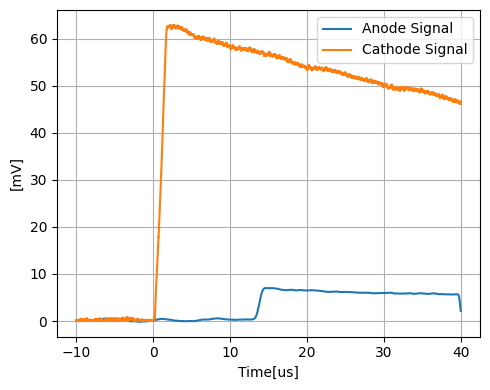

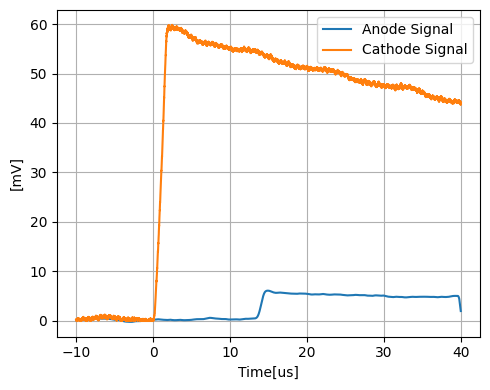

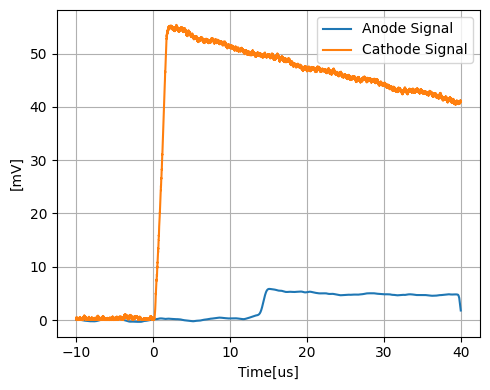

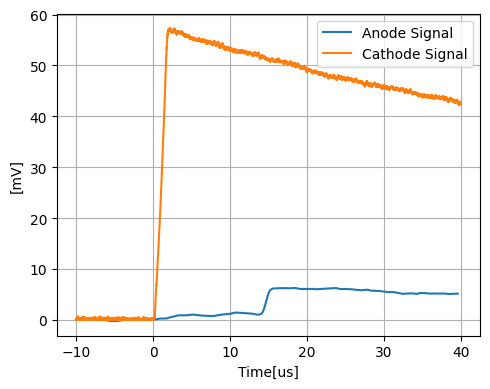

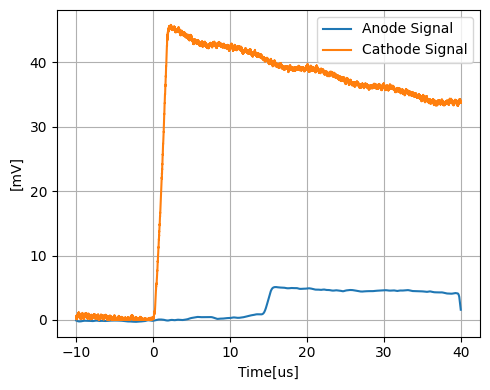

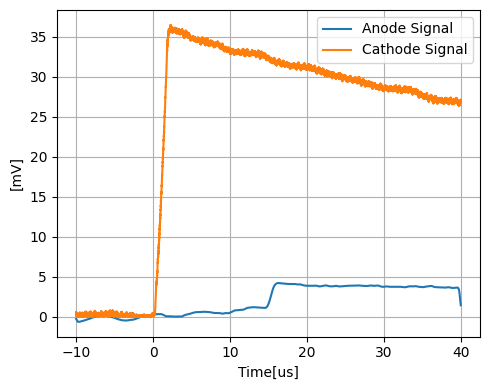

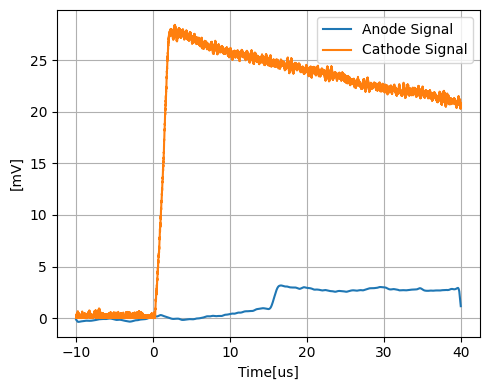

In [23]:
DF_all=pd.DataFrame.from_dict(AnalyzeRun([176,177,178,179,180,181,182,334,333,332,331,330,385,386,387,388,389,437,438,439,440,441,442,443,444,445,446],[100],[100],debug=1,plot=False))
DF=DV_ana(DF_all)
DF_full=LT_ana(DF)

## Dec. 13th "Full"

Run  502   BG-  504
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  503   BG-  505
Stepsize 100 , DiffSize 100
Run  506   BG-  508
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  507   BG-  509
Stepsize 100 , DiffSize 100
Issue with sin fit
Run  510   BG-  512
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  511   BG-  513
Stepsize 100 , DiffSize 100
Run  514   BG-  516
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  515   BG-  517
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  518   BG-  520
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  519   BG-  521
Stepsize 100 , DiffSize 100
Run  536   BG-  537
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
issue with weird data
Run  538   BG-  539
Stepsize 100 , DiffSize 100
issue with weird data
Run  540   BG-  541
St

C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:204: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3,dx=plt.subplots(figsize=(5,4))


Run  544   BG-  545
Stepsize 100 , DiffSize 100
issue with weird data


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,bx=plt.subplots(figsize=(5,4))


Run  584   BG-  585
Stepsize 100 , DiffSize 100


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_25308\592800598.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  if 1==1: fig, ax = plt.subplots(2,2, figsize=(12,7))


Run  586   BG-  587
Stepsize 100 , DiffSize 100
Run  588   BG-  589
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  548   BG-  549
Stepsize 100 , DiffSize 100
Run  550   BG-  551
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  552   BG-  553
Stepsize 100 , DiffSize 100
An error occurred: list index out of range
Issue with bg  553
Run  554   BG-  555
Stepsize 100 , DiffSize 100
Run  556   BG-  557
Stepsize 100 , DiffSize 100
Run  558   BG-  559
Stepsize 100 , DiffSize 100
issue with weird data
Run  560   BG-  561
Stepsize 100 , DiffSize 100
Run  562   BG-  563
Stepsize 100 , DiffSize 100
Run  564   BG-  565
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  566   BG-  567
Stepsize 100 , DiffSize 100
Run  568   BG-  569
Stepsize 100 , DiffSize 100
Run  570   BG-  571
Stepsize 100 , DiffSize 100
issue with weird data
Run  572   BG- 

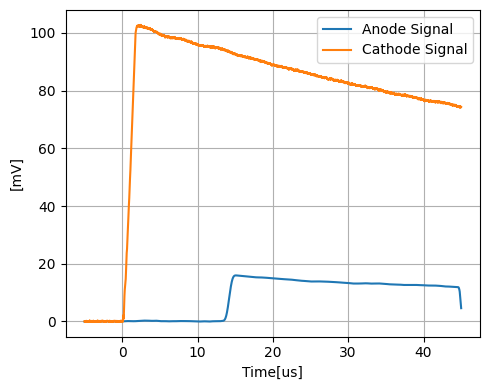

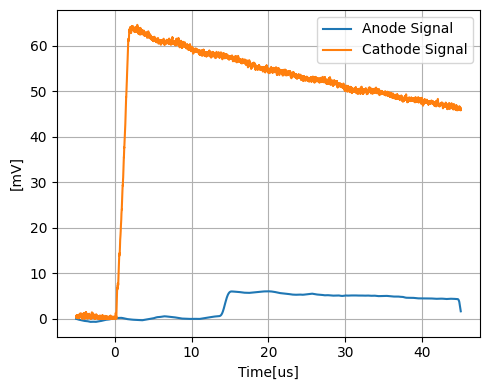

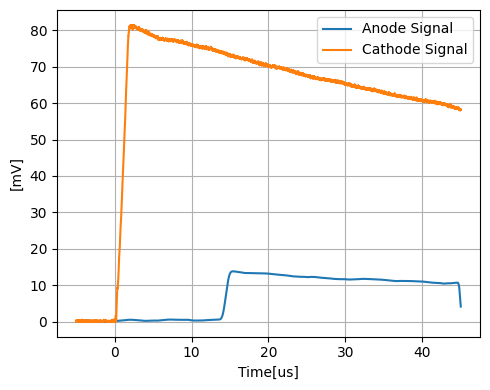

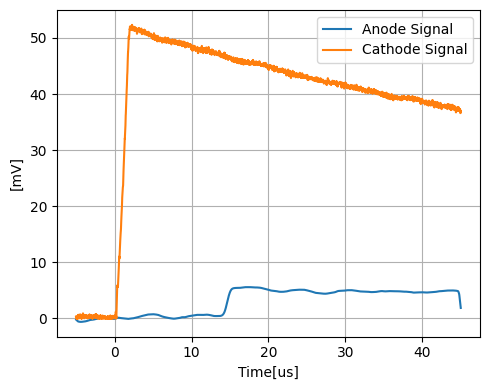

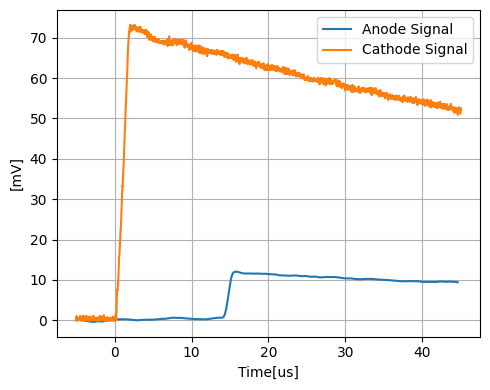

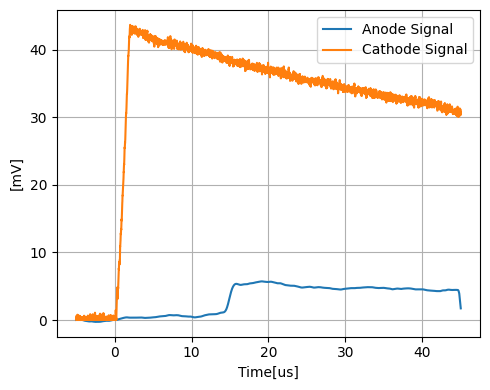

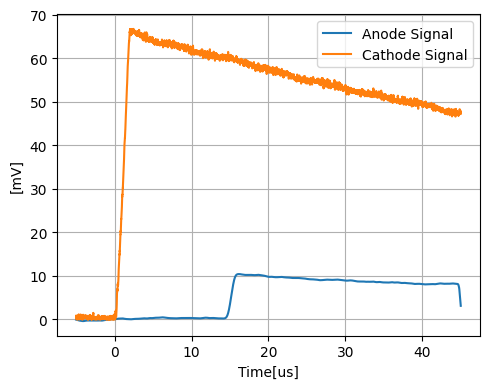

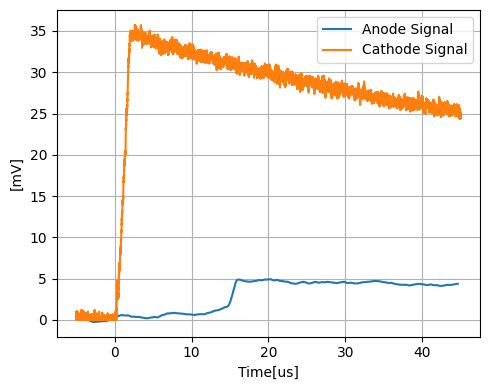

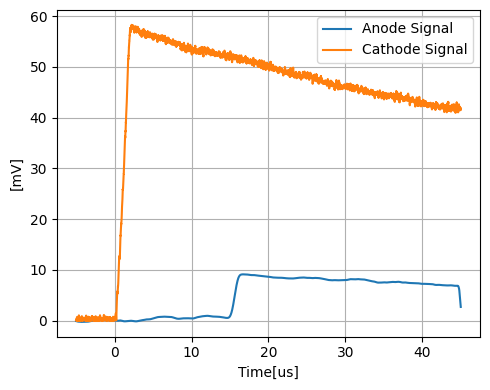

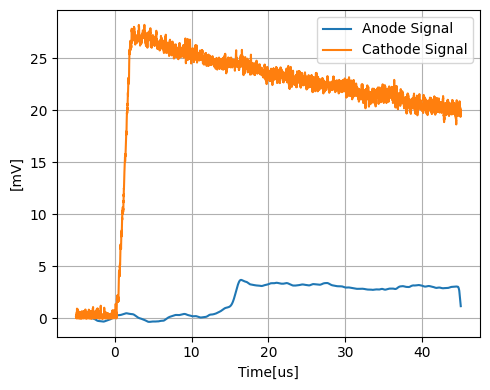

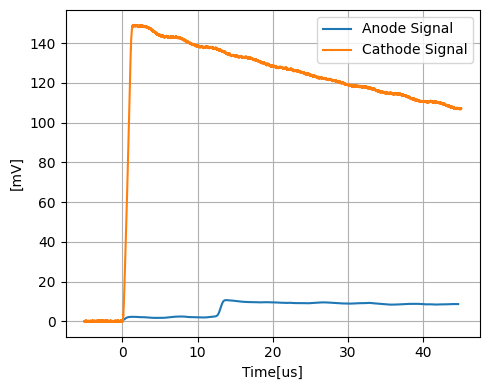

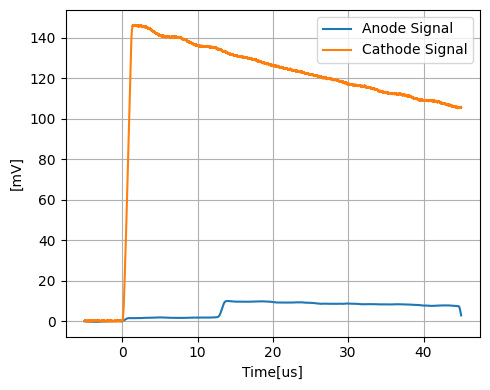

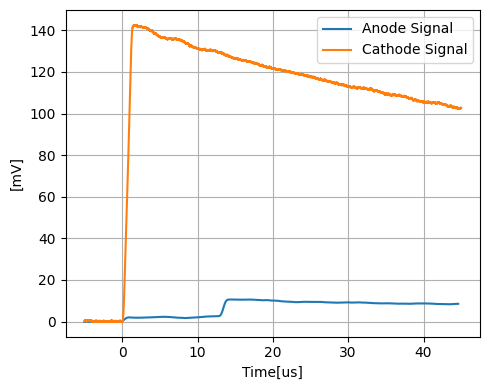

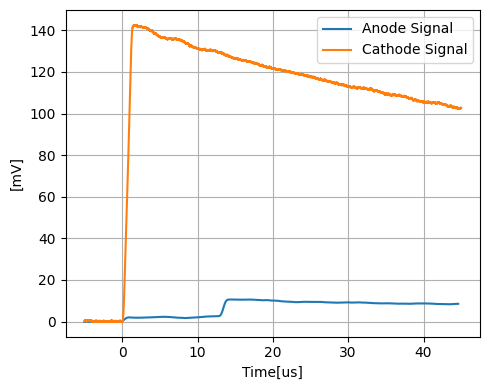

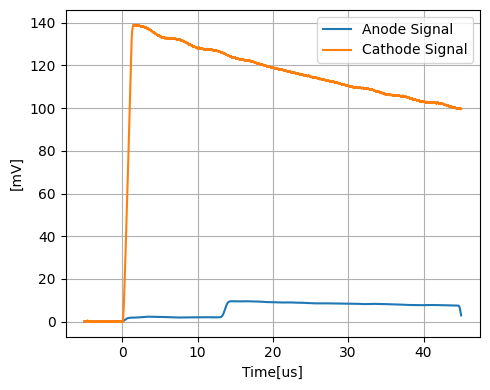

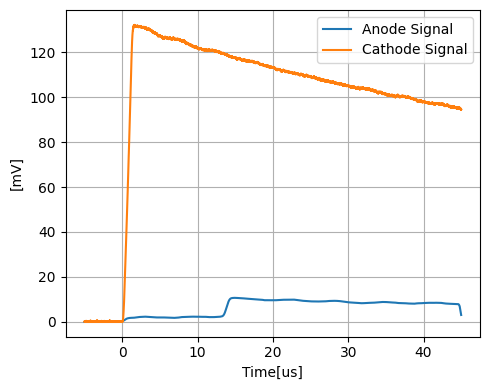

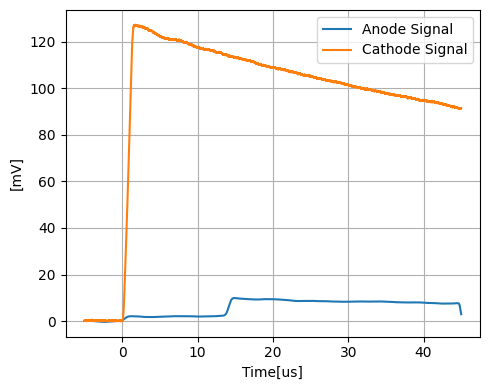

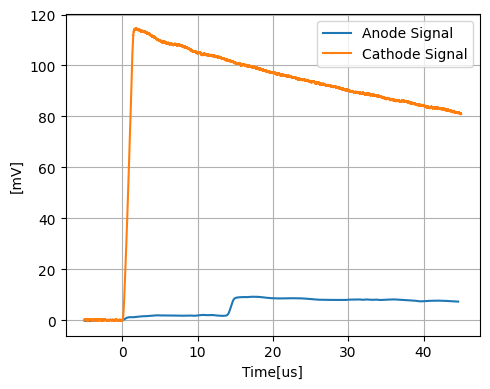

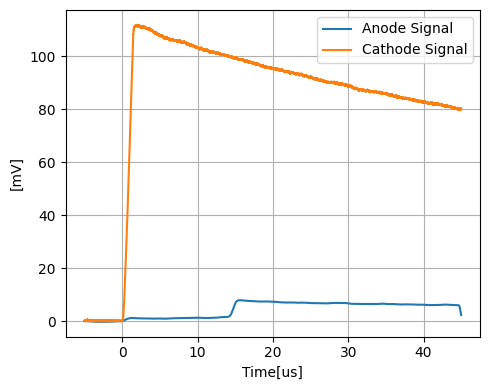

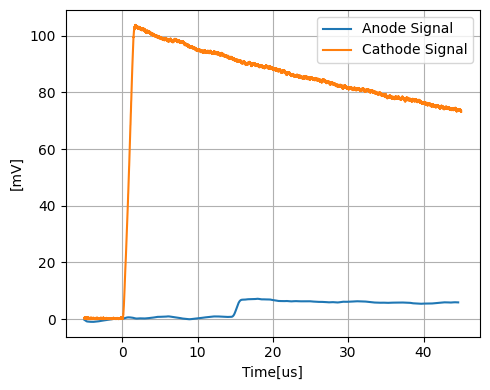

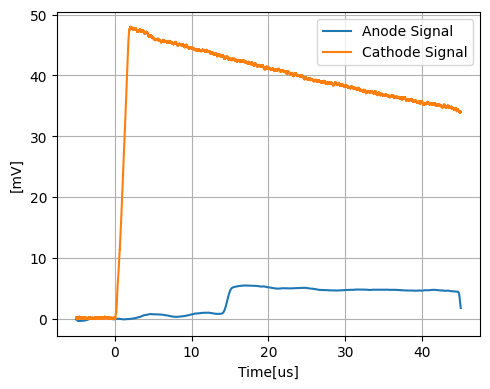

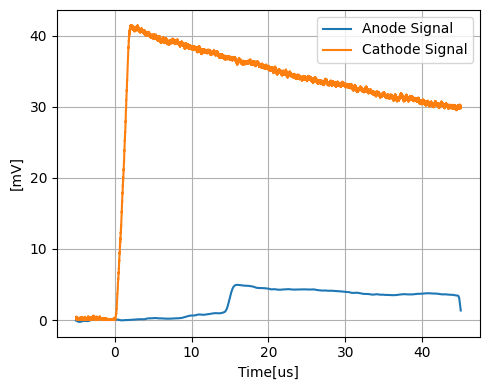

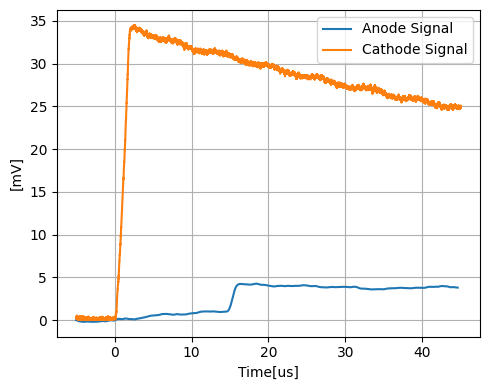

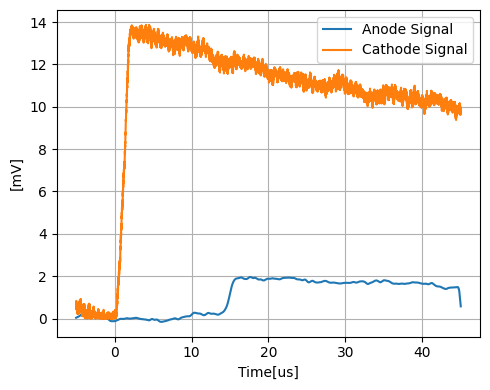

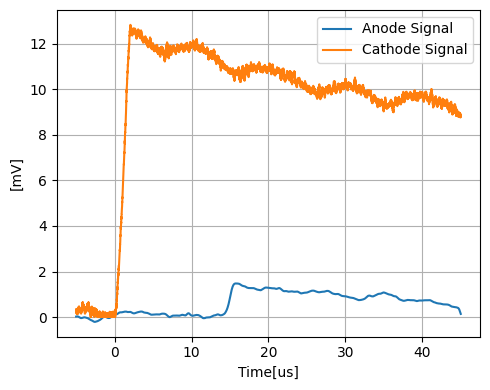

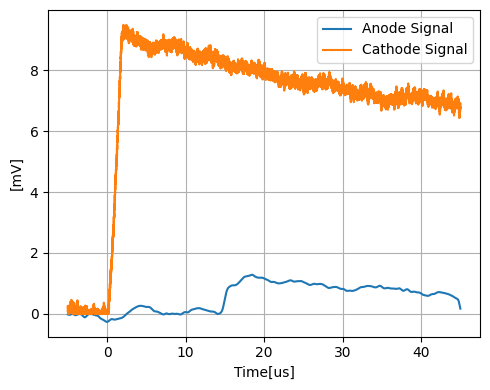

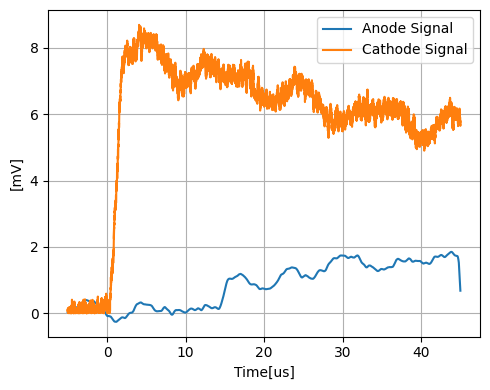

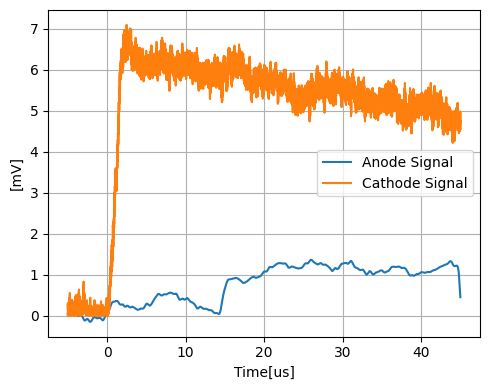

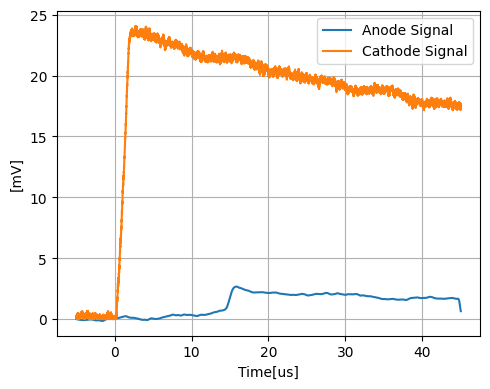

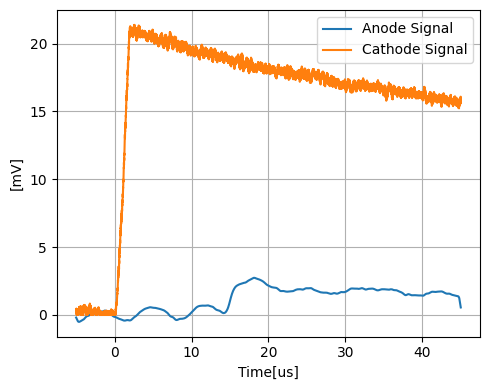

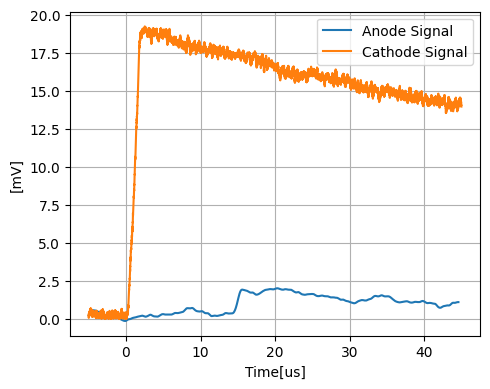

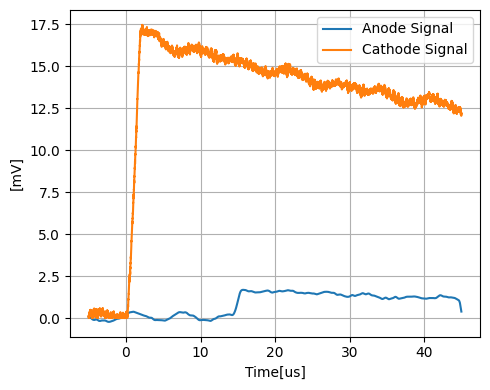

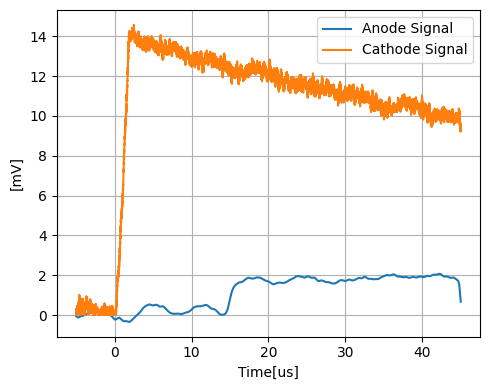

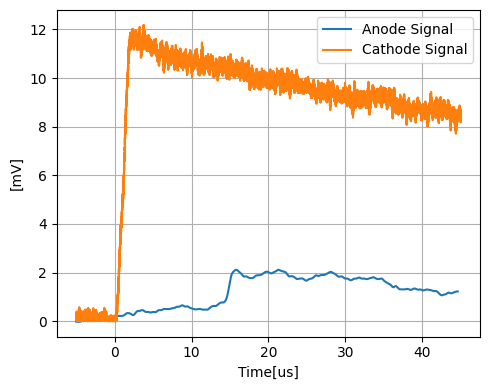

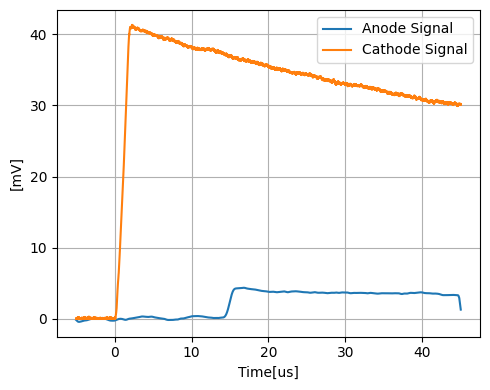

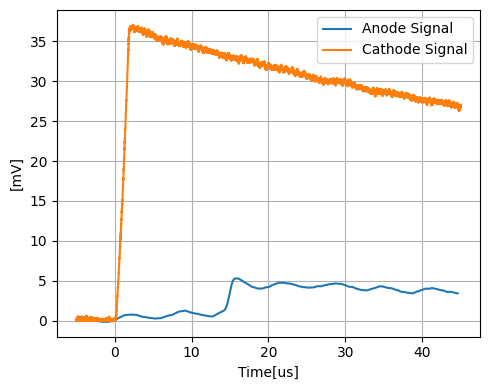

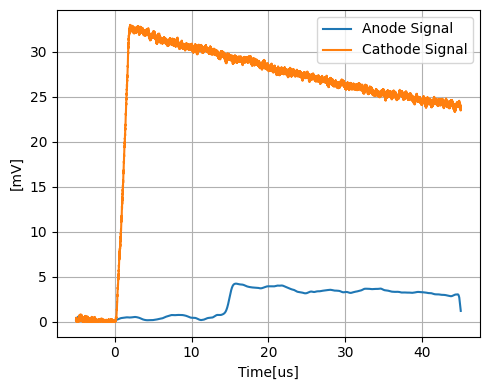

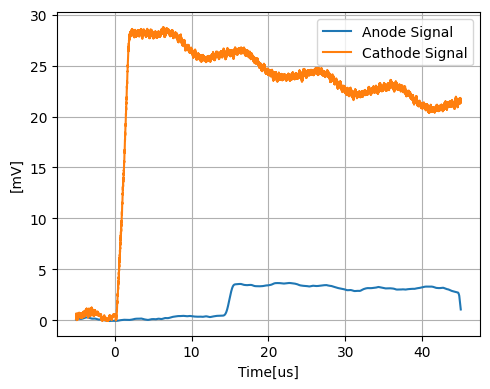

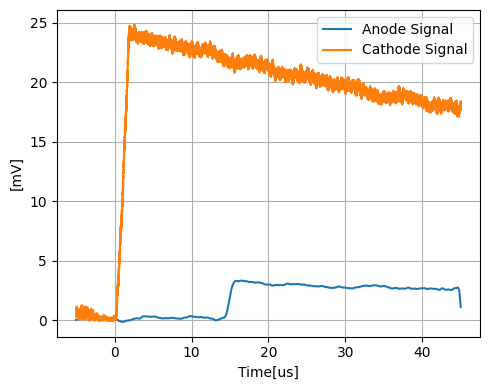

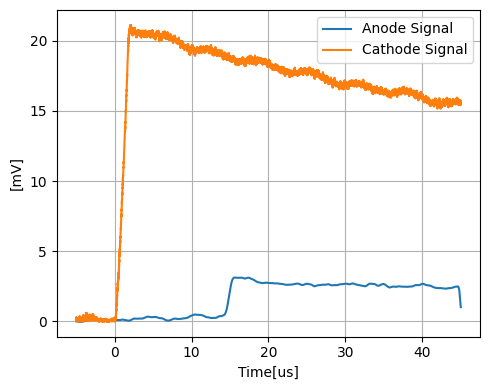

In [26]:
Dec13Full= AnalyzeRun(Dec13Full_runlist,[100],[100],debug=1,plot=False)
Dec13Full_ana=DV_ana(Dec13Full)
Dec13Full_ana=LT_ana(Dec13Full_ana)

## Jan 28th Drift field Sweep

Run  599   BG-  605
Stepsize 100 , DiffSize 100
Run  600   BG-  606
Stepsize 100 , DiffSize 100
Run  601   BG-  607
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  602   BG-  608
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  603   BG-  609
Stepsize 100 , DiffSize 100
Run  604   BG-  610
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit


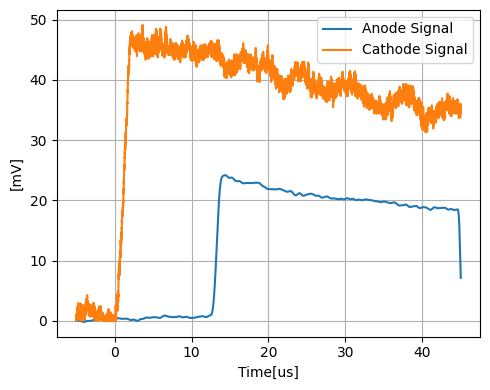

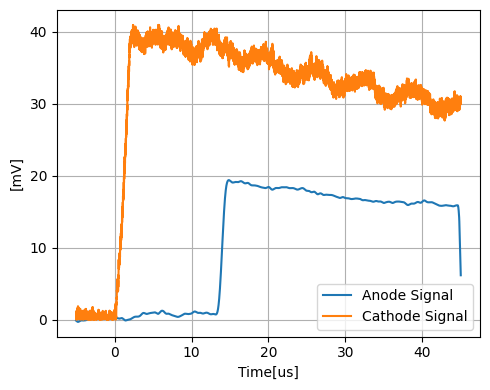

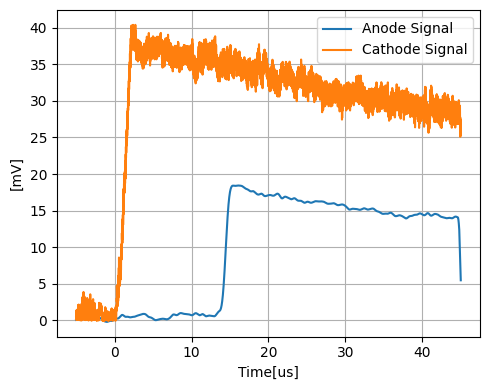

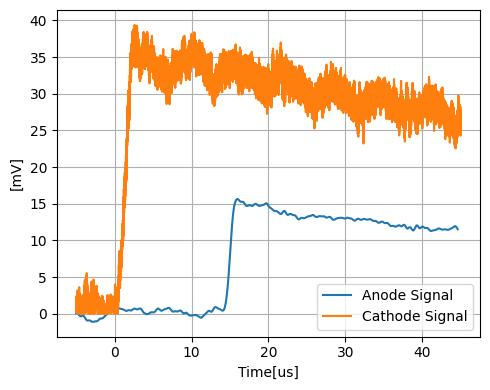

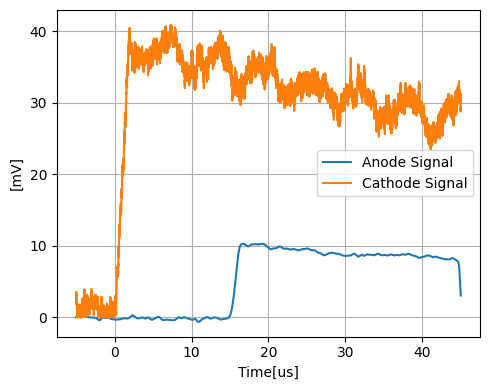

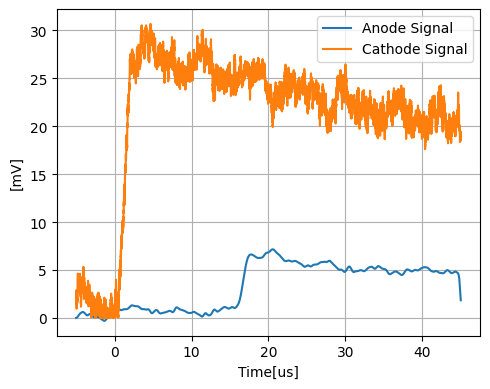

In [15]:
Jan28_DS = AnalyzeRun([599,600,601,602,603,604],[100],[100],debug=1,plot=False)
Jan28_DS_ana=DV_ana(Jan28_DS)
Jan28_DS_ana=LT_ana(Jan28_DS_ana)

## Feb 4th Drift field sweep

Run  625   BG-  626
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  627   BG-  628
Stepsize 100 , DiffSize 100
Run  629   BG-  630
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  631   BG-  632
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
Run  643   BG-  644
Stepsize 100 , DiffSize 100
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502


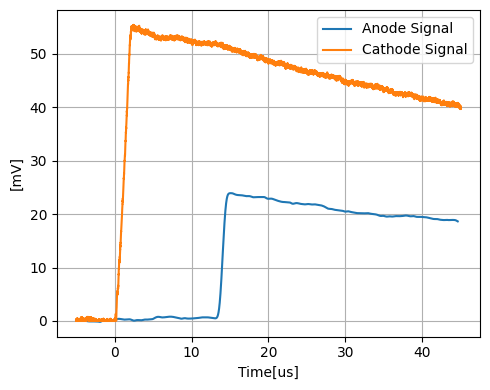

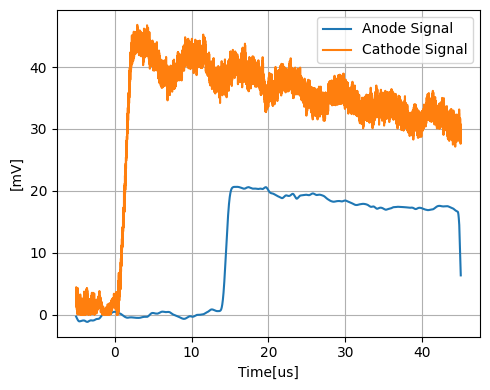

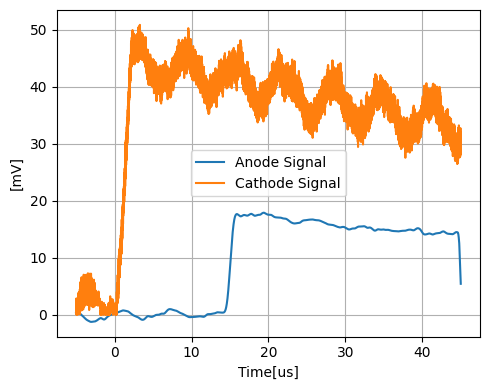

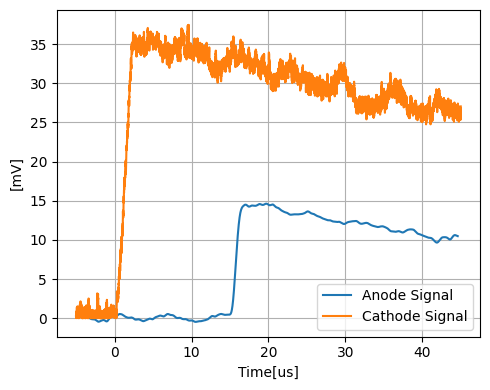

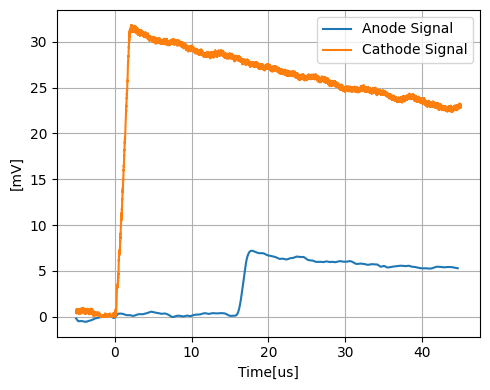

In [ ]:
Runlist_Feb04_DS=[625,627,629,631,643]

Feb04_DS = AnalyzeRun(Runlist_Feb04_DS,[100],[100],debug=1,plot=False)
Feb04_DS_ana=DV_ana(Feb04_DS)
Feb04_DS_ana=LT_ana(Feb04_DS_ana)

## April 4th 

Run  793   BG-  794
Stepsize 100 , DiffSize 100
Time step size:  0.004
Mod step 100, res mod 1.0000, Zero time index 2511, Zero time 0.0387
starting sin removal
Start  26 6500  stop  50 12500
Tail Only
P0 [27.288779477777773, -0.001]
bounds ([20.466584608333328, -0.01], [34.11097434722222, 0.0001])
Only exp tail paramaters [ 3.07327679e+01 -9.14444650e-03]
Fit P0 [0.9488394434198906, 0.14, 0]
Bounds ([0, 0, -3.14], [1.2334912764458579, 1, 3.14])
Parameters [ 0.194  0.141 -3.14 ]
Covariance [[ 3.71282769e-05 -1.16499070e-07  2.63176595e-05]
 [-1.16499070e-07  4.78415565e-07 -8.47230112e-05]
 [ 2.63176595e-05 -8.47230112e-05  1.59287024e-02]]
Fit deviation from fitting data 0.22456851023103755
starting sin removal for bg
X and Y need to be equal in length and need two more data points
 X:  12503  Y : 12502
DF length  12503 resolution 0.004

 Time @ zero 	 time @ 0 + 500
0.03866672 	 2.03866666

modifed diffsize  100
fit start 3761 5.03866658
fit stop 12502 40.00266559
sec fit 17070 34.13

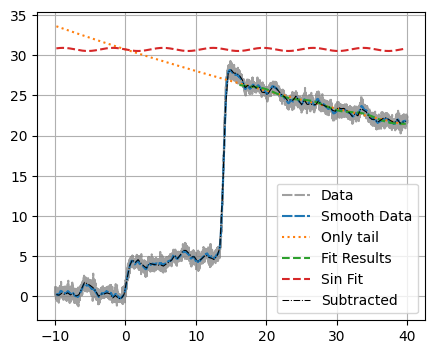

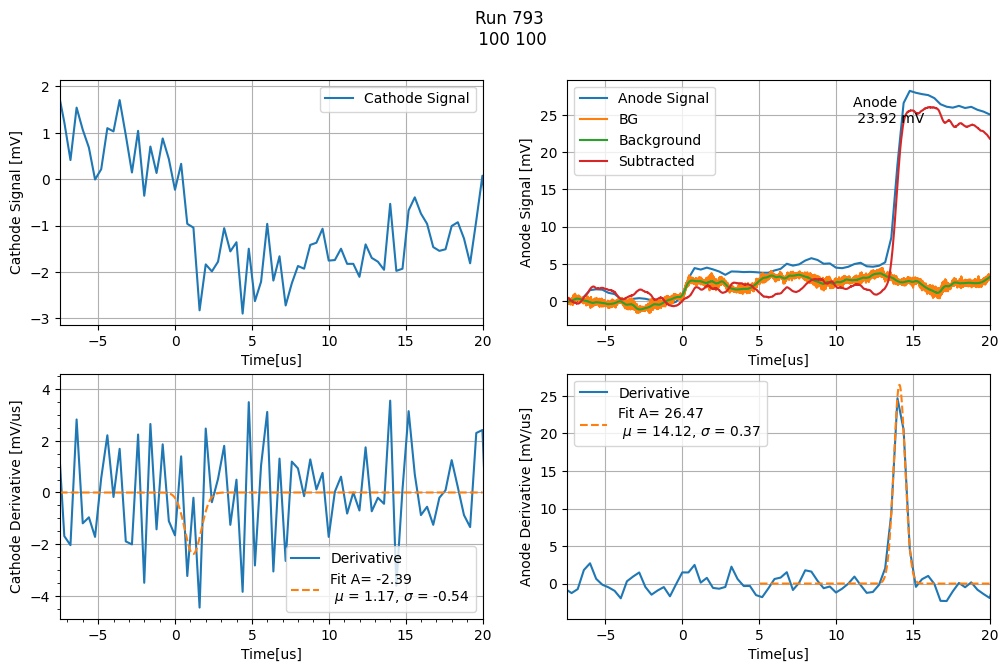

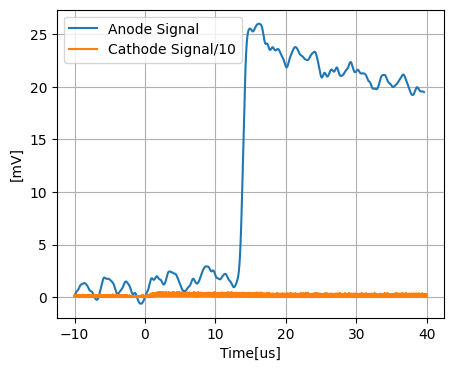

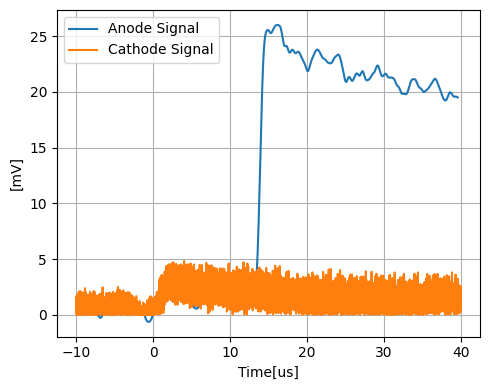

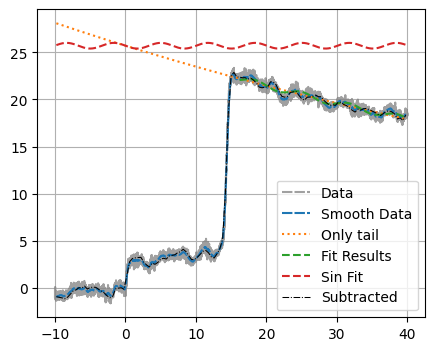

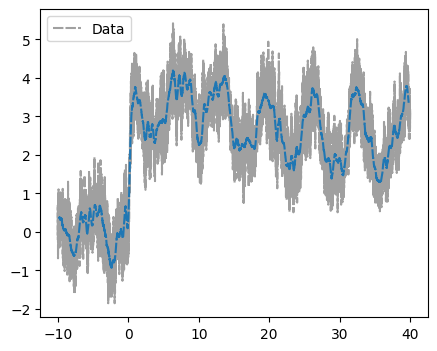

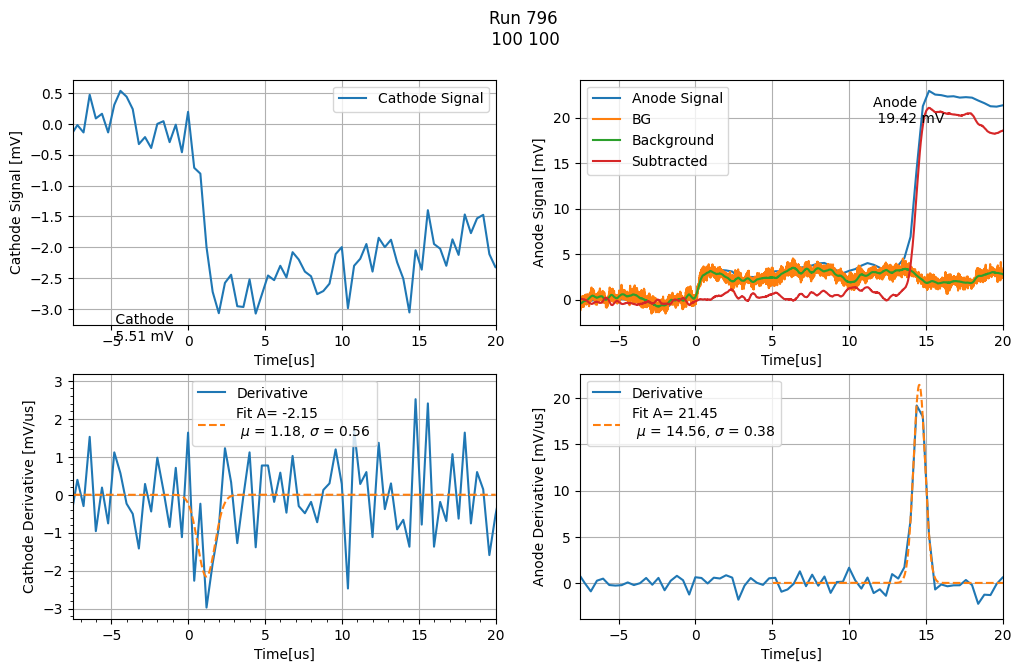

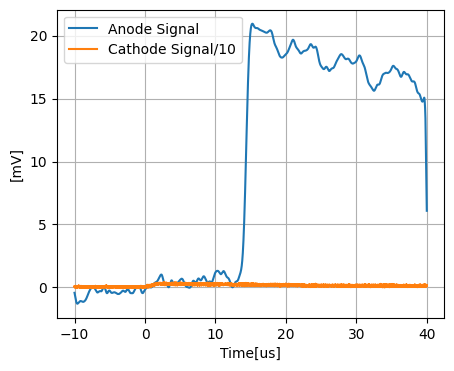

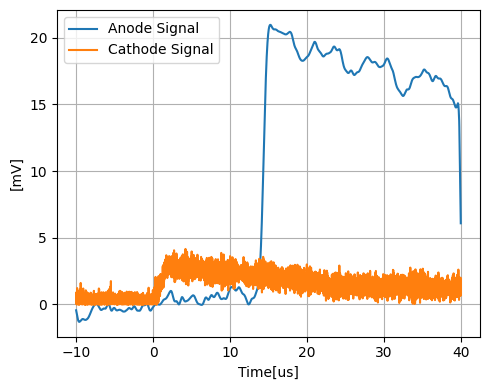

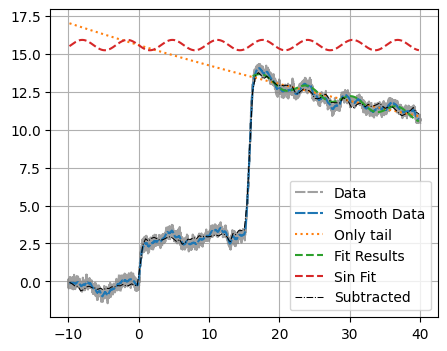

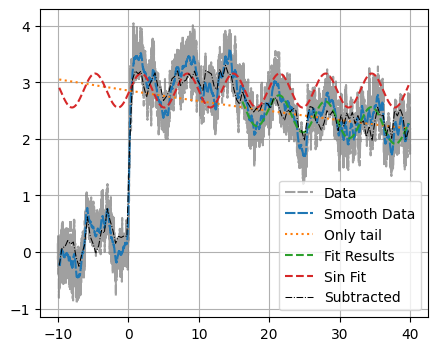

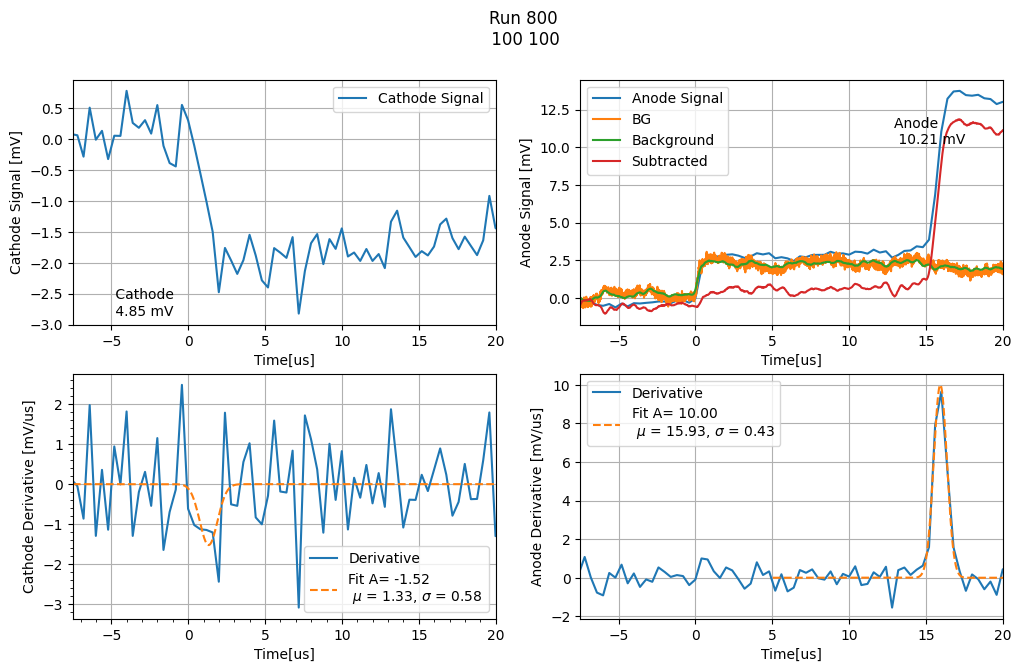

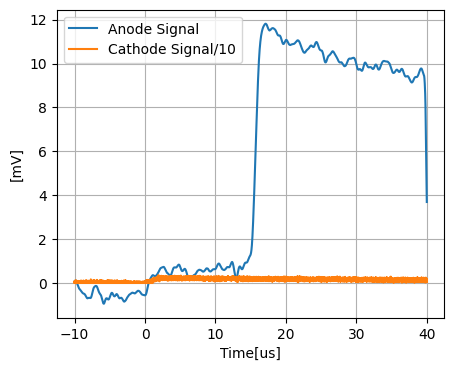

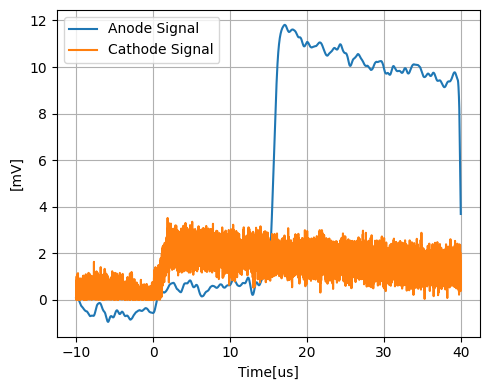

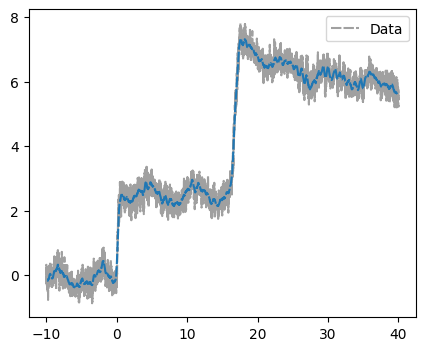

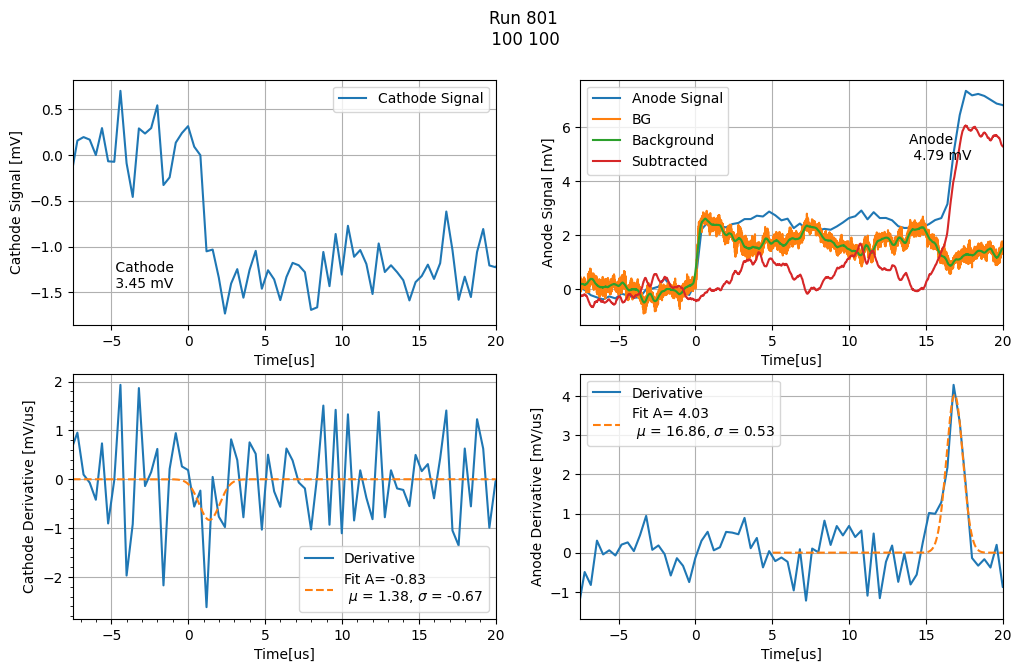

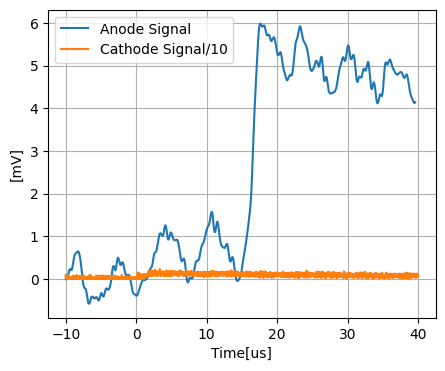

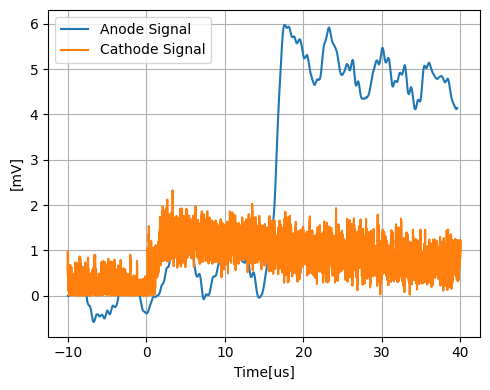

In [19]:
Runlist_April4_DS=[793,796,787,800,801]

April4_DS = AnalyzeRun(Runlist_April4_DS,[100],[100],debug=1,plot=False)
April4_DS_ana=DV_ana(April4_DS)
April4_DS_ana=LT_ana(April4_DS_ana)

Run  811   BG-  810
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit
Run  808   BG-  809
Stepsize 100 , DiffSize 100
Run  812   BG-  813
Stepsize 100 , DiffSize 100
Weird structure skipping sin fit


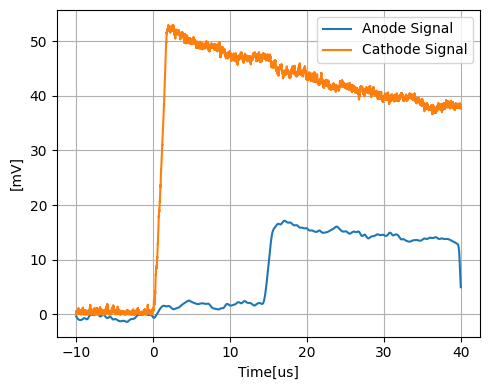

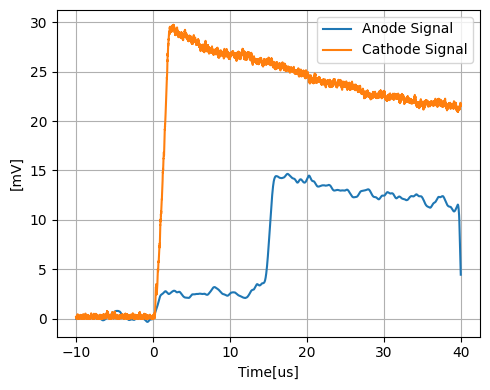

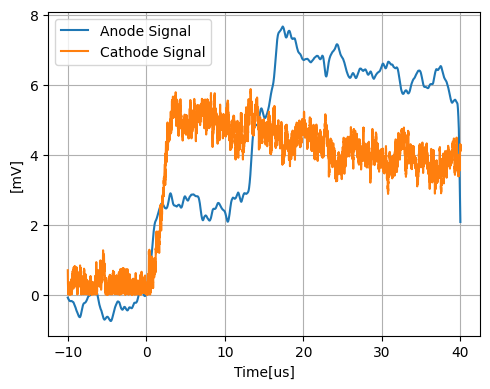

In [20]:
Runlist_April4_ExS=[811,808,812]

April4_ExS = AnalyzeRun(Runlist_April4_ExS,[100],[100],debug=1,plot=False)
April4_ExS_ana=DV_ana(April4_ExS)
April4_ExS_ana=LT_ana(April4_ExS_ana)

# Drift Velocity plot

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 [Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0'),
  Text(0, 2.5, '2.5')])

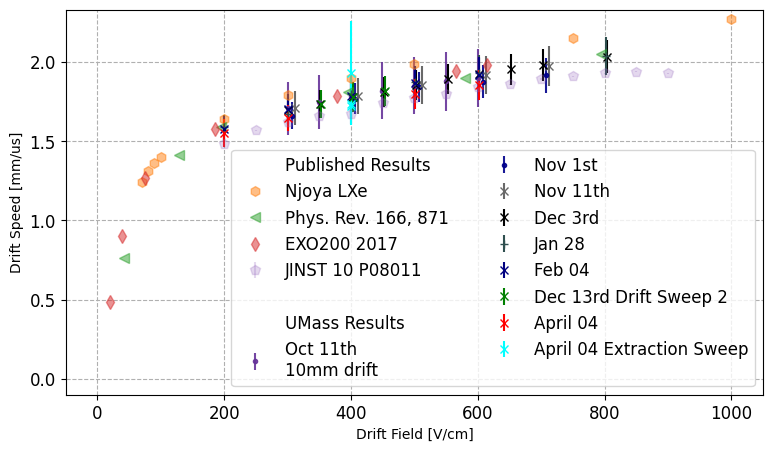

In [77]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0



ax.errorbar(x=0,y=0,fmt=" ",label="Published Results")

ax.errorbar(x=njoya_x,y=njoya_y,fmt=" ",marker="h",
            ms=7,alpha=0.5,label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,fmt=" ", marker="<",
            ms=7,alpha=0.5,label="Phys. Rev. 166, 871 ")

ax.errorbar(x=EXO200[0],y=EXO200[1],fmt=" ", marker="d",
            ms=7,alpha=0.5,label="EXO200 2017")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            ms=7,
            yerr=JINST_2015_dict["Error"],alpha=0.25,label="JINST 10 P08011 ")

ax.errorbar(x=0,y=0,fmt=" ",label=" ")
ax.errorbar(x=0,y=0,fmt=" ",label="UMass Results")

DF=DF_full[DF_full["Run"].isin(Runlist_Oct11)]
plt.errorbar(x=DF["Drift Field"],y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" ",alpha=0.9,
             marker=".",color="rebeccapurple",label="Oct 11th\n10mm drift")


DF=DF_full[DF_full["Run"].isin(Runlist_Nov1)]
plt.errorbar(x=DF["Drift Field"]+5,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" ",alpha=0.9,
             marker=".",color="darkblue",label="Nov 1st")

DF=DF_full[DF_full["Run"].isin(Runlist_Nov11)]
plt.errorbar(x=DF["Drift Field"]+10,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" ",
             marker="x",color="dimgray",label="Nov 11th")

DF=DF_full[DF_full["Run"].isin(Runlist_Dec3)]
plt.errorbar(x=DF["Drift Field"]-0,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
             ,marker="x",color="black",label="Dec 3rd")


DF=Jan28_DS_ana[Jan28_DS_ana["Run"].isin(Runlist_Jan28_DS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
             ,marker="+",color="darkslategray",label="Jan 28")

DF=Feb04_DS_ana[Feb04_DS_ana["Run"].isin(Runlist_Feb04_DS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
            ,marker="x",color="navy",label="Feb 04")

DF=Dec13Full_ana[Dec13Full_ana["Run"].isin(Runlist_Dec13_DS2)]
plt.errorbar(x=DF["Drift Field"]+1,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
            ,marker="x",color="green",label="Dec 13rd Drift Sweep 2")


DF=April4_DS_ana[April4_DS_ana["Run"].isin(Runlist_April4_DS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
             ,marker="x",color="red",label="April 04")

DF=April4_ExS_ana[April4_ExS_ana["Run"].isin(Runlist_April4_ExS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["Drift Vel"],yerr=DF["Drift Vel Error"],fmt=" "
             ,marker="x",color="Cyan",label="April 04 Extraction Sweep")




ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")

#ax.text(400,1.25, "UMass 2024",size=25,alpha=0.25)

#ax.set_ylim(1.5,2.33)
ax.set_ylim(-0.1,2.33)
ax.grid(visible=True, linestyle='--', alpha=1)
# Add legend
plt.legend(fontsize=12,ncol=2)

# Customize tick marks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Lifetime

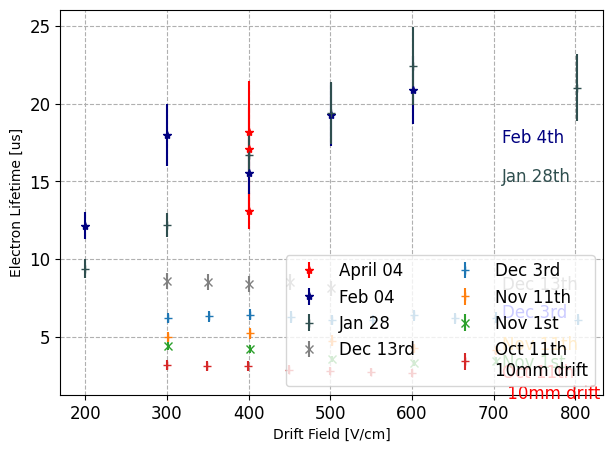

In [30]:
fig,ax = plt.subplots(figsize=(7,5))


DF=April4_ExS_ana[April4_ExS_ana["Run"].isin(Runlist_April4_ExS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" "
             ,marker="*",color="red",label="April 04")


DF=Feb04_DS_ana[Feb04_DS_ana["Run"].isin(Runlist_Feb04_DS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" "
             ,marker="*",color="navy",label="Feb 04")


DF=Jan28_DS_ana[Jan28_DS_ana["Run"].isin(Runlist_Jan28_DS)]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" "
             ,marker="+",color="darkslategray",label="Jan 28")


DF=Dec13Full_ana[Dec13Full_ana["Run"].isin([502,506,510,514,518])]
plt.errorbar(x=DF["Drift Field"]-1,y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" "
             ,marker="x",color="grey",label="Dec 13rd")


DF=DF_full[DF_full["Run"].isin(Runlist_Dec3)]
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" ",marker="+",label="Dec 3rd")

DF=DF_full[DF_full["Run"].isin(Runlist_Nov11)]
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" ",marker="+",label="Nov 11th")

DF=DF_full[DF_full["Run"].isin(Runlist_Nov1)]
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" ",marker="x",label="Nov 1st")

DF=DF_full[DF_full["Run"].isin(Runlist_Oct11)]
plt.errorbar(x=DF["Drift Field"],y=DF["LifeTime"],yerr=DF["Lifetime Error"],fmt=" ",marker="+",label="Oct 11th\n10mm drift")


plt.ylabel("Electron Lifetime [us]")
plt.xlabel("Drift Field [V/cm]")
#plt.ylim(0,25.5)
#plt.ylim(0,10.1)
plt.grid(visible=True, linestyle='--', alpha=1)
# Add legend
plt.legend(fontsize=12,ncol=2,loc="lower right")



plt.text(710,17.5,"Feb 4th",color="navy",size=12)
plt.text(710,15,"Jan 28th",color="darkslategray",size=12)
plt.text(710,8,"Dec 13th",color="gray",size=12)
plt.text(710,6.2,"Dec 3rd",color="Blue",size=12)
plt.text(710,4.2,"Nov 11th",color="Orange",size=12)
plt.text(710,3,"Nov 1st",color="Green",size=12)
plt.text(710,1.,"Oct 11th\n 10mm drift",color="Red",size=12)

# Customize tick marks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
print("")

# Analyze single Wavefom
## Anode

C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20250128-00600
C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20250128/20250128-00600
\\172.24.54.234/NAS-Lab28/Data/20250128-00600
located :  \\172.24.54.234/NAS-Lab28/Data/20250128-00600
\\172.24.54.234/NAS-Lab28/Data/20250128/20250128-00600
20250128
00600
\\172.24.54.234/NAS-Lab28/Data/20250128-00600
\\172.24.54.234/NAS-Lab28/Data/20250128-00600
(us),(V),(mV),(mV),(mV),(mV)

C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20250128-00606
C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20250128/20250128-00606
\\172.24.54.234/NAS-Lab28/Data/20250128-00606
located :  \\172.24.54.234/NAS-Lab28/Data/20250128-00606
\\172.24.54.234/NAS-Lab28/Data/20250128/20250128-00606
20250128
00606
\\172.24.54.234/NAS-Lab28/Data/20250128-00606
\\172.24.54.234/NAS-Lab28/Data/20250128-00606
(us),(V),(mV),(mV),(mV),(mV)

Start  27.5 6875  stop  50 12500
Tail Only
P0 [20.151961

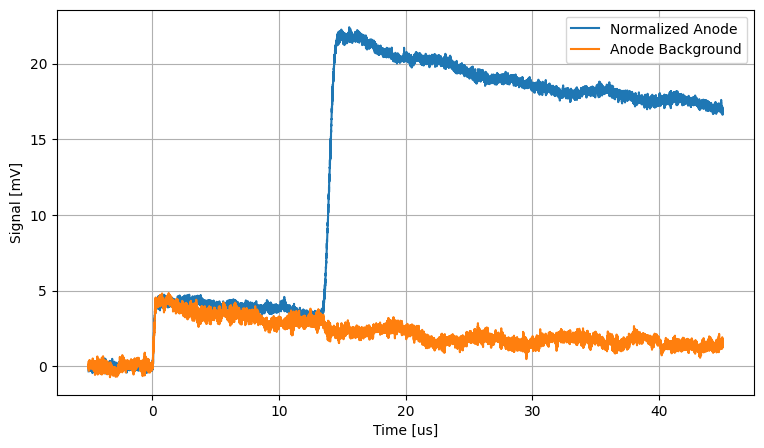

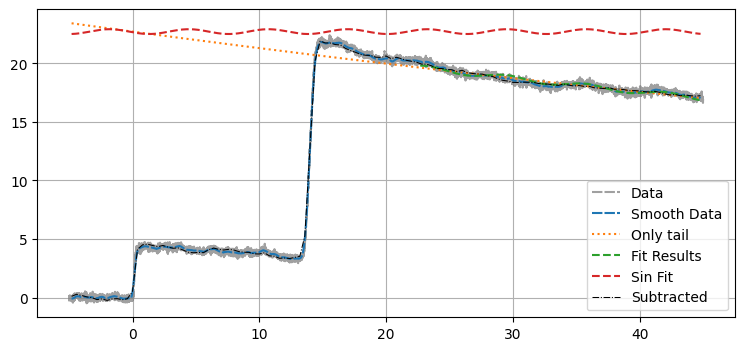

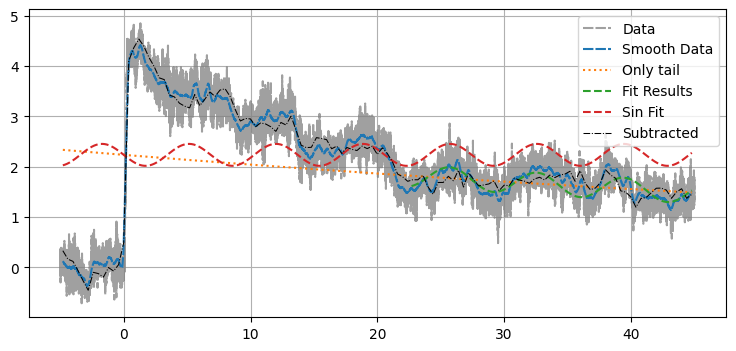

In [ ]:
stepcounts=[100]
diffsizes=[200]
debug=10
plot=True
savefig=True
runnumber=600

#def Analyze_Anode(runnumber=0,stepcounts=[100],diffsizes=[200],debug=1,plot=True,savefig=True):

if 1 ==1:
    AnalysisResults={}

    Waveform = GetWaveForm(runnumber=runnumber,debug=debug)


    time_resolution = Waveform["Time"][1] - Waveform["Time"][0]
    #Find the average anode for the first 5 us and subtract to normalize. 
    anode_normalize = Waveform["Avg Anode"][:int(5/time_resolution)].mean()
    Waveform["Normalized Anode"] = Waveform["Avg Anode"] - anode_normalize

    #Grab the anode off background run:

    background_runnumber= GetBGRun(runnumber)
    
    if background_runnumber == -1:
        n=len(Waveform["Time"])
        background_waveform=pd.DataFrame({"Avg Cathode": [0] *n , "Avg Anode": [0] * n})
    else:
        background_waveform = GetWaveForm(runnumber=background_runnumber,debug=debug)
    #Find the average anode for the first 5 us and subtract to normalize.    
    background_normalize = background_waveform["Avg Anode"][:int(5/time_resolution)].mean()
    Waveform["Normalized Anode Background"] = background_waveform["Avg Anode"] - background_normalize

    if plot:
        fig_anode, ax_anode = plt.subplots(figsize=(9,5))
        ax_anode.grid()
        ax_anode.set_xlabel("Time [us]")
        ax_anode.set_ylabel("Signal [mV]")

        ax_anode.errorbar(x=Waveform["Time"],y=Waveform["Normalized Anode"], label="Normalized Anode")
        ax_anode.errorbar(x=Waveform["Time"],y=Waveform["Normalized Anode Background"], label="Anode Background")
        

    #Find and remove noise
    Anode_noise_params, Anode_noise_cov =GetSinBG(Waveform["Time"],Waveform["Normalized Anode"],27.5,50,debug=debug,plot=plot)
    BG_noise_params, BG_noise_cov = GetSinBG(Waveform["Time"],Waveform["Normalized Anode Background"],27.5,50,debug=debug,plot=plot)

    AnalysisResults["Anode Noise Frq"]=Anode_noise_params[1]
    AnalysisResults["Anode Noise Amp"]=Anode_noise_params[0]
    AnalysisResults["Anode Signal Decay Rate"]=Anode_noise_params[4]
    AnalysisResults["BG Noise Frq"]=BG_noise_params[1]
    AnalysisResults["BG Noise Amp"]=BG_noise_params[0]
    AnalysisResults["BG Signal Decay Rate"]=BG_noise_params[4]


    if plot:
        ax_anode.legend()
4